# Data Sources



## Dietary Data

In [ ]:
# Load necessary libraries
import pandas as pd
import requests
import tempfile
from io import BytesIO

# Function to download and read XPT file into a DataFrame
def download_and_read_xpt(url):
    response = requests.get(url)
    with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
        tmp_file.write(response.content)
        tmp_file_path = tmp_file.name
    return pd.read_sas(tmp_file_path, format='xport')

# Download and read the first XPT file
url1 = "https://wwwn.cdc.gov/nchs/nhanes/2017-2018/DR1TOT_J.XPT"
df1 = download_and_read_xpt(url1)

# List of columns to be removed
columns_to_remove = ['DR1DRSTZ', 'DR1EXMER', 'DR1LANG', 'DR1MRESP', 'DR1HELP']  # Replace these with your specific column names

# Drop the specified columns
df1 = df1.drop(columns=columns_to_remove)

# Save the modified DataFrame to a new CSV file
df1.to_csv('TotalNutrientIntakes.csv', index=False)

# Download and read the second XPT file
url2 = "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DS1TOT_J.XPT"
df2 = download_and_read_xpt(url2)

# Drop the specified columns
df2 = df2.drop(columns=columns_to_remove)

# Save the modified DataFrame to a new CSV file
df2.to_csv('DietarySupplementUse24Hour.csv', index=False)

# Load the CSV files
df1 = pd.read_csv('TotalNutrientIntakes.csv')
df2 = pd.read_csv('DietarySupplementUse24Hour.csv')

# Perform left joins
merged_df = df1.merge(df2, on='SEQN', how='left')

# Print the resulting dataframe to verify the changes
print(merged_df)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('mergedDietary.csv', index=False)

          SEQN      WTDRD1_x      WTDR2D_x  DRABF  DRDINT_x  DR1DBIH_x  \
0      93703.0  5.397605e-79           NaN    NaN       NaN        NaN   
1      93704.0  8.171401e+04  8.244287e+04    2.0       2.0        7.0   
2      93705.0  7.185561e+03  5.640391e+03    2.0       2.0        5.0   
3      93706.0  6.463883e+03  5.397605e-79    2.0       1.0        NaN   
4      93707.0  1.533378e+04  2.270707e+04    2.0       2.0       14.0   
...        ...           ...           ...    ...       ...        ...   
8699  102952.0  1.381296e+04  2.868593e+04    2.0       2.0       22.0   
8700  102953.0  5.063236e+04  5.397605e-79    2.0       1.0        2.0   
8701  102954.0  1.108127e+04  8.924895e+03    2.0       2.0        2.0   
8702  102955.0  2.752985e+04  3.629955e+04    2.0       2.0       15.0   
8703  102956.0  6.944741e+04  9.275688e+04    2.0       2.0       10.0   

      DR1DAY_x  DBQ095Z  DBD100  DRQSPREP  ...  DS1TPHOS  DS1TMAGN  DS1TIRON  \
0          NaN      NaN     NaN

##Questionnaire Data

In [ ]:
import requests
import pandas as pd
import tempfile

dic = {
    # "DEMO_J.XPT": ["SEQN"],
    "ALQ_J.XPT": ['ALQ111',"ALQ121"],
    "BPQ_J.XPT": ["BPQ040A"],
    'HSQ_J.XPT': ['HSD010'],
    'DIQ_J.XPT': ['DIQ010'],
    'DBQ_J.XPT': ['DBQ700','DBD900','DBD905', 'DBD910'],
    'DPQ_J.XPT': ['DPQ020'],
    'PAQ_J.XPT': ['PAQ605', 'PAQ610', 'PAD615', 'PAQ620', 'PAQ625',
                  'PAD630', 'PAQ635', 'PAQ640', 'PAD645', 'PAQ650', 'PAQ655',
                  'PAD660', 'PAQ665', 'PAQ670', 'PAD675', 'PAD680' ],
    # 'RXQ_RX_J.XPT': [''],
    'SLQ_J.XPT': ['SLD012', 'SLQ050'],
    'SMQ_J.XPT': ['SMQ020', 'SMQ040'],
    # 'WHQ_J.XPT': ['WHD010', 'WHD020', 'WHQ030']
}

def getdata(url, collist):
    with tempfile.NamedTemporaryFile(delete=False) as tf:
        # Download the file
        response = requests.get(url)
        tf.write(response.content)
        temp_file_path = tf.name

    # Read the XPT file
    df = pd.read_sas(temp_file_path, format='xport', encoding='latin1')

    # # check if col exists
    # if col in df.columns:
    #   print(col + ' good')
    # else:
    #   print(col + ' not found')

    # Extract specified columns
    collist.append('SEQN')
    extracted_columns = df[collist]
    return extracted_columns

# get base - demographic
with tempfile.NamedTemporaryFile(delete=False) as tf:
  response = requests.get('https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT')
  tf.write(response.content)
  temp_file_path = tf.name

df = pd.read_sas(temp_file_path, format='xport', encoding='latin1')

df = df[['SEQN']]
# print(df.shape)

# Iterate over the dictionary and print keys and values
for key, value in dic.items():
    url = 'https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/' + key
    edf = getdata(url, value)
    # # check for unique id - all passed
    # if edf['SEQN'].is_unique:
    #   print(key +' is unique')
    # else:
    #   print (key +' need check')

    df = pd.merge(df, edf, on='SEQN', how='left')

df.to_csv('questionnaire_combine.csv')


## Demographic Data

In [ ]:
!pip install pyreadstat
import pandas as pd
import pyreadstat
import requests
import tempfile
import os

# URL of the .xpt file
url = 'https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT'
# Fetch the file from the URL
response = requests.get(url)
response.raise_for_status()  # Check that the request was successful

# Create a temporary file
with tempfile.NamedTemporaryFile(delete=False, suffix='.xpt') as tmp_file:
    tmp_file.write(response.content)
    tmp_file_path = tmp_file.name

# Read the .xpt file
df, meta = pyreadstat.read_xport(tmp_file_path)

# Remove the temporary file
os.unlink(tmp_file_path)

demo_df = df[['SEQN','DMDBORN4', 'DMDCITZN', 'DMDEDUC2', 'DMDEDUC3', 'DMDFMSIZ', 'DMDHHSIZ', 'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE', 'DMDMARTL', 'DMDYRSUS', 'DMQADFC', 'DMQMILIZ', 'INDFMIN2', 'INDFMPIR', 'INDHHIN2', 'RIAGENDR', 'RIDAGEMN', 'RIDAGEYR', 'RIDEXAGM', 'RIDEXPRG', 'RIDRETH3', 'RIDSTATR']]

demo_df.to_csv("demo.csv")

##Examination Data

In [ ]:
import requests
import pandas as pd
import tempfile

dic = {
    # "DEMO_J.XPT": ["SEQN"],
    "BPX_J.XPT": ['BPXPLS','BPXPULS', 'BPXPTY','BPXML1','BPXSY1','BPXDI1','BPXSY2', 'BPXDI2','BPXSY3','BPXDI3'],
    "BMX_J.XPT": ['BMXWT',	'BMXHT',	'BMXBMI',	'BMXLEG',	'BMXARML',	'BMXARMC',	'BMXWAIST',	'BMXHIP'],
    'DXXAG_J.XPT': ['DXXANFM','DXXANLM', 'DXXANTOM', 'DXXGYFM','DXXGYLM','DXXGYTOM','DXXAGRAT','DXXAPFAT', 'DXXGPFAT', 'DXXSATA','DXXSATM','DXXSATV','DXXTATA','DXXTATM','DXXTATV','DXXVFATA','DXXVFATM','DXXVFATV'],
    'DXXSPN_J.XPT': ['DXXOSBMD', 'DXXOSBMC'],
    'DXX_J.XPT': ['DXDTOBMD', 'DXDTOFAT','DXXTRFAT'],
    'OHXREF_J.XPT': ['OHAROCDT', 'OHAROCGP','OHAROCDE']
}

def getdata(url, collist):
    with tempfile.NamedTemporaryFile(delete=False) as tf:
        # Download the file
        response = requests.get(url)
        tf.write(response.content)
        temp_file_path = tf.name

    # Read the XPT file
    df = pd.read_sas(temp_file_path, format='xport', encoding='latin1')

    # # check if col exists
    # if col in df.columns:
    #   print(col + ' good')
    # else:
    #   print(col + ' not found')

    # Extract specified columns
    collist.append('SEQN')
    extracted_columns = df[collist]
    return extracted_columns

# get base - demographic
with tempfile.NamedTemporaryFile(delete=False) as tf:
  response = requests.get('https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT')
  tf.write(response.content)
  temp_file_path = tf.name

df = pd.read_sas(temp_file_path, format='xport', encoding='latin1')

df = df[['SEQN']]
# print(df.shape)

# Iterate over the dictionary and print keys and values
for key, value in dic.items():
    url = 'https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/' + key
    edf = getdata(url, value)
    # # check for unique id - all passed
    # if edf['SEQN'].is_unique:
    #   print(key +' is unique')
    # else:
    #   print (key +' need check')

    df = pd.merge(df, edf, on='SEQN', how='left')

df.to_csv('examination.csv')

##Laboratory Data


In [ ]:
import requests
import pandas as pd
import io

# Function to download and read xpt files
def download_xpt(url):
    response = requests.get(url)
    response.raise_for_status()  # Check if the download was successful
    with io.BytesIO(response.content) as tf:
        df = pd.read_sas(tf, format='xport')
    return df

# URLs of the files
urls = {
    "demo": "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.xpt",
    "albumin": "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/ALB_CR_J.xpt",
    "cholesterol": "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/HDL_J.xpt",
    "continine": "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/COT_J.xpt"
}

# Download and process the files
pre_demo = download_xpt(urls["demo"])
demo = pre_demo[["SEQN"]]

pre_cholesterol = download_xpt(urls["cholesterol"])
cholesterol = pre_cholesterol[["SEQN", "LBDHDD"]]

pre_continine = download_xpt(urls["continine"])
continine = pre_continine[["SEQN", "LBXCOT"]]

# Merge the DataFrames on 'SEQN'
merged_df = pd.merge(demo, cholesterol, on="SEQN", how="inner")
merged_df = pd.merge(merged_df, continine, on="SEQN", how="inner")

print(merged_df.head())

# Save the result to a CSV file
merged_df.to_csv("lab_data.csv", index=False)



      SEQN  LBDHDD  LBXCOT
0  93705.0    60.0   0.028
1  93706.0    47.0   0.138
2  93707.0    68.0   0.555
3  93708.0    88.0   0.011
4  93709.0    65.0  54.300


# Data Import & Merge

In [ ]:
import pandas as pd

# Load the CSV files into DataFrames
df1 = pd.read_csv('demo.csv', index_col=0)
df2 = pd.read_csv('examination.csv', index_col=0)
df3 = pd.read_csv('lab_data.csv', index_col=0)
df4 = pd.read_csv('mergedDietary.csv',index_col=0)
df5 = pd.read_csv('questionnaire_combine.csv', index_col=0)

# Perform the left join on the 'id' column
df1 = df1.merge(df2, on='SEQN', how='left')
df1 = df1.merge(df3, on='SEQN', how='left')
df1 = df1.merge(df4, on='SEQN', how='left')
df1 = df1.merge(df5, on='SEQN', how='left')

df1.describe()


,SEQN,DMDBORN4,DMDCITZN,DMDEDUC2,DMDEDUC3,DMDFMSIZ,DMDHHSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,...,PAQ655,PAD660,PAQ665,PAQ670,PAD675,PAD680,SLD012,SLQ050,SMQ020,SMQ040
count,9254.000000,9254.000000,9251.000000,5569.000000,2306.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,...,1434.000000,1431.000000,5856.000000,2308.000000,2301.000000,5.846000e+03,6113.000000,6161.000000,5856.000000,2359.000000
mean,98329.500000,1.237519,1.118582,3.525768,6.349523,3.592609,3.717419,0.498163,0.878647,0.490707,...,3.479079,83.176101,1.605874,3.649480,68.284659,3.895582e+02,7.658842,1.742574,1.597165,2.225943
std,2671.544029,1.562210,0.466721,1.240231,5.843226,1.758527,1.712127,0.803878,1.061327,0.755305,...,2.978859,267.651485,0.488704,3.871216,215.166165,7.718131e+02,1.669706,0.486460,0.490510,0.926147
min,93703.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,10.000000,1.000000,1.000000,10.000000,5.397605e-79,2.000000,1.000000,1.000000,1.000000
25%,96016.250000,1.000000,1.000000,3.000000,3.000000,2.000000,2.000000,0.000000,0.000000,0.000000,...,2.000000,42.500000,1.000000,2.000000,30.000000,1.800000e+02,7.000000,1.000000,1.000000,1.000000
50%,98329.500000,1.000000,1.000000,4.000000,6.000000,4.000000,4.000000,0.000000,0.000000,0.000000,...,3.000000,60.000000,2.000000,3.000000,60.000000,3.000000e+02,8.000000,2.000000,2.000000,3.000000
75%,100642.750000,1.000000,1.000000,4.000000,9.000000,5.000000,5.000000,1.000000,2.000000,1.000000,...,4.000000,120.000000,2.000000,5.000000,60.000000,4.800000e+02,8.500000,2.000000,2.000000,3.000000
max,102956.000000,99.000000,9.000000,9.000000,66.000000,7.000000,7.000000,3.000000,3.000000,3.000000,...,99.000000,9999.000000,2.000000,99.000000,9999.000000,9.999000e+03,14.000000,9.000000,2.000000,3.000000


# Variable Preprocessing

## Dietary Data

In [ ]:
# Dietary preprocessing
import pandas as pd
import numpy as np
# Change the value 2 to 0 in the specified columns DS1DS and DS1AN
df1['DS1DS'] = df1['DS1DS'].apply(lambda x: 0 if x == 2 else x)
df1['DS1AN'] = df1['DS1AN'].apply(lambda x: 0 if x == 2 else x)

# List of columns to be modified
columns_to_modify = [
    "DRABF", "DR1STY", "DRQSDIET",
    "DRD340", "DRD350A", "DRD350B", "DRD350C", "DRD350D", "DRD350E", "DRD350F", "DRD350G",
    "DRD350H", "DRD350I", "DRD350J", "DRD350K", "DRD360", "DRD370A", "DRD370B", "DRD370C",
    "DRD370D", "DRD370E", "DRD370F", "DRD370G", "DRD370H", "DRD370I", "DRD370J", "DRD370K",
    "DRD370L", "DRD370M", "DRD370N", "DRD370O", "DRD370P", "DRD370Q", "DRD370R", "DRD370S",
    "DRD370T", "DRD370U", "DRD370V"
]

# Function to change values in the columns to be modified
def change_values(x):
    if x == 2:
        return 0
    elif x in [7, 9]:
        return np.nan
    return x

# Apply the function to the specified columns
for column in columns_to_modify:
    df1[column] = df1[column].apply(change_values)

# List of columns to be dropped
columns_to_drop = [
    "DRQSDT1", "DRQSDT2", "DRQSDT3", "DRQSDT4", "DRQSDT5", "DRQSDT6", "DRQSDT7", "DRQSDT8",
    "DRQSDT9", "DRQSDT10", "DRQSDT11", "DRQSDT12", "DRQSDT91", "DR1SKY", "DR1TWSZ"
]

# Drop the specified columns
df1 = df1.drop(columns=columns_to_drop)

# Modify additional specified columns
df1['DBQ095Z'] = df1['DBQ095Z'].apply(lambda x: 1 if x in [2, 3] else (0 if x == 4 else (np.nan if x in [91, 99] else x)))
df1['DBD100'] = df1['DBD100'].apply(lambda x: 1 if x in [2, 3] else (0 if x == 1 else (np.nan if x in [7, 9] else x)))
df1['DRQSPREP'] = df1['DRQSPREP'].apply(lambda x: 0 if x in [1, 2] else (1 if x in [3, 4] else (np.nan if x == 9 else x)))
df1['DR1_300'] = df1['DR1_300'].apply(lambda x: 1 if x in [1, 2] else (0 if x in [3, 7] else (np.nan if x == 9 else x)))

# Create new columns based on the criteria
df1['DR1TSFAT_criteria'] = df1['DR1TSFAT'].apply(lambda x: 1 if x <= 20 else 0)
df1['DR1TSUGR_criteria'] = df1['DR1TSUGR'].apply(lambda x: 1 if x <= 50 else 0)
df1['DR1TSODI_criteria'] = df1['DR1TSODI'].apply(lambda x: 1 if x <= 2000 else 0)
df1['DR1TFIBE_criteria'] = df1['DR1TFIBE'].apply(lambda x: 1 if x >= 31 else 0)

# Create the "unhealthy condition" column
df1['unhealthy_condition'] = df1[['DR1TSFAT_criteria', 'DR1TSUGR_criteria', 'DR1TSODI_criteria', 'DR1TFIBE_criteria']].sum(axis=1).apply(lambda x: 1 if x <= 2 else 0)


## Questionnaire Data

In [ ]:
import numpy as np
import pandas as pd

# Questionnaire Preprocessing

cd1 = {2:0, 7:np.nan, 9: np.nan, '.':np.nan} # for q that has no continuous value
td = {1: 'Excellent', 0: 'Very Good', 3: 'Good', 4: 'Fair', 5: 'Poor'} # combination use with cd1: 2>0>very good
cd2 = {7777:np.nan, 9999:np.nan, '.':np.nan}


# Alcohol
## ALQ111 - Ever had a drink of any kind of alcohol
df1['ALQ111'] = df1['ALQ111'].replace(cd1)

## ALQ121 - Past 12 mo how often have alcohol drink
# tdp = {0: 'never', 1: 'everyday', 2:'nearly everyday', 3:'3-4time/week',
#        4:'2/week', 5:'1/week', 6:'2-3/month', 7:'1/month',
#        8:'7-11/year', 9:'3-6/year', 10:'1-2/year',
#        77:np.nan, 99:np.nan, '.':np.nan}
# 1: drink a lot 0: no drinking
tdp = {2:1, 3:1, 4:0, 5:0, 6:0, 7:0, 8:0,9:0, 10:0, 77:np.nan, 99:np.nan, '.':np.nan}
df1['ALQ121'] = df1['ALQ121'].replace(tdp)
df1['ALQ121'] = df1['ALQ121'].apply(lambda x: int(x) if not pd.isna(x) else x)

# Hypertension
## BPQ040A - Taking prescription for hypertension
## !!!!!Note: high missing value
df1['BPQ040A'] = df1['BPQ040A'].replace(cd1)

# Health conditon
## HSD010 - General health condition
df1['HSD010'] = df1['HSD010'].replace(cd1)
df1['HSD010'] = df1['HSD010'].replace(td)


# Diabetes
## DIQ010 - Doctor told you have diabetes
df1['DIQ010'] = df1['DIQ010'].replace(3, 1)
df1['DIQ010'] = df1['DIQ010'].replace(cd1)

# Diet
## [Categorical]DBQ700 - How healthy is the diet
df1['DBQ700'] = df1['DBQ700'].replace(cd1)
df1['DBQ700'] = df1['DBQ700'].replace(td)

# DBD900 - # of meals from fast food or pizza place
df1['DBD900'] = df1['DBD900'].replace(cd2)
df1['DBD900'] = df1['DBD900'].replace(5555, 22)

# DBD905 - # of ready-to-eat foods in past 30 days
df1['DBD905'] = df1['DBD905'].replace(cd2)
df1['DBD905'] = df1['DBD905'].replace(6666, 91)

# DBD910 - # of frozen meals/pizza in past 30 days
df1['DBD910'] = df1['DBD910'].replace(cd2)
df1['DBD910'] = df1['DBD910'].replace(6666, 91)

# Mental
## DPQ020 - Feeling down, depressed, or hopeless (over 2 week period)
tdp = {0: 'No', 1: 'sometimes', 2: 'more than half', 3:'almost everyday',
       7:np.nan, 9:np.nan, '.':np.nan}
df1['DPQ020'] = df1['DPQ020'].replace(tdp)

# Physical Activity (time period -  week)
## PAQ605 - Vigorous work activity
df1['PAQ605'] = df1['PAQ605'].replace(cd1)

## PAQ610 - Number of days vigorous work
tdp = {77:np.nan, 99:np.nan, '.':np.nan}
df1['PAQ610'] = df1['PAQ610'].replace(tdp)

## PAD615 - Minutes vigorous-intensity work
df1['PAD615'] = df1['PAD615'].replace(cd2)

## PAQ620 - Moderate work activity
df1['PAQ620'] = df1['PAQ620'].replace(cd1)

## PAQ625 - Number of days moderate work
tdp = {77:np.nan, 99:np.nan, '.':np.nan}
df1['PAQ625'] = df1['PAQ625'].replace(tdp)

## PAD630 - Minutes moderate-intensity work
df1['PAD630'] = df1['PAD630'].replace(cd2)

## PAQ635 - Walk or bicycle
df1['PAQ635'] = df1['PAQ635'].replace(cd1)

## PAQ640 - Number of days walk or bicycle
tdp = {77:np.nan, 99:np.nan, '.':np.nan}
df1['PAQ640'] = df1['PAQ640'].replace(tdp)

## PAD645 - Minutes walk/bicycle for transportation
df1['PAD645'] = df1['PAD645'].replace(cd2)

## PAQ650 - Vigorous recreational activities
df1['PAQ650'] = df1['PAQ650'].replace(cd1)

## PAQ655 - Days vigorous recreational activities
tdp = {77:np.nan, 99:np.nan, '.':np.nan}
df1['PAQ655'] = df1['PAQ655'].replace(tdp)

## PAD660 - Minutes vigorous recreational activities
df1['PAD660'] = df1['PAD660'].replace(cd2)

# PAQ665 - Moderate recreational activities
df1['PAQ665'] = df1['PAQ665'].replace(cd1)

## PAQ670 - Days moderate recreational activities
tdp = {77:np.nan, 99:np.nan, '.':np.nan}
df1['PAQ670'] = df1['PAQ670'].replace(tdp)

## PAD675 - Minutes moderate recreational activities
df1['PAD675'] = df1['PAD675'].replace(cd2)

## PAD680 - Minutes sedentary activity
df1['PAD680'] = df1['PAD680'].replace(cd2)


# create exercise
# (PAQ665 or PAQ650 = 1 -> 1)
df1['exercise'] = df1.apply(lambda row: 1 if row['PAQ650'] == 1 or row['PAQ665'] == 1 else 0, axis=1)

# Sleep disorder
## SLD012 - Sleep hours - weekdays or workdays
df1['SLD012'] = df1['SLD012'].replace('.', np.nan)

## SLQ050 - Ever told doctor had trouble sleeping?
df1['SLQ050'] = df1['SLQ050'].replace(cd1)

## create sleep_well
df1['sleep_well'] = (df1['SLD012'] >= 7).astype(int)


# Smoking
# SMQ020 - Smoked at least 100 cigarettes in life
df1['SMQ020'] = df1['SMQ020'].replace(cd1)


print(df1['SMQ040'].value_counts())
# [Categorical] SMQ040 - Do you now smoke cigarettes?
df1['SMQ040'] = df1['SMQ040'].replace(1, 'Everyday')
df1['SMQ040'] = df1['SMQ040'].replace(2, 'Someday')
df1['SMQ040'] = df1['SMQ040'].replace(3, 'Not')
df1['SMQ040'] = df1['SMQ040'].replace('.', np.nan)

df1['SMQ_everyday'] = df1['SMQ040']
df1['SMQ_everyday'] = df1['SMQ_everyday'].apply(lambda x: 1 if x == 1 or x == 2 else 0)

print(df1['SMQ_everyday'].value_counts())

SMQ040
3.0    1338
1.0     805
2.0     216
Name: count, dtype: int64
SMQ_everyday
0    9254
Name: count, dtype: int64


<ipython-input-109-d9e535bd84d8>:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1['exercise'] = df1.apply(lambda row: 1 if row['PAQ650'] == 1 or row['PAQ665'] == 1 else 0, axis=1)
<ipython-input-109-d9e535bd84d8>:131: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1['sleep_well'] = (df1['SLD012'] >= 7).astype(int)
<ipython-input-109-d9e535bd84d8>:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

## Demographic Data

In [ ]:
import numpy as np

###demo data https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.htm#DMDEDUC3 ###

# Education
## 20+ dummy conversion needed
conversion_dict = {7: np.nan, ".":np.nan}
df1['DMDEDUC2'] = df1['DMDEDUC2'].replace(conversion_dict)
## 19- dummy conversion needed
conversion_dict = {66: np.nan, 9: np.nan, ".":np.nan}
df1['DMDEDUC3'] = df1['DMDEDUC3'].replace(conversion_dict)

# Marital dummy conversion needed
conversion_dict = {77: np.nan, ".":np.nan}
df1['DMDMARTL'] = df1['DMDMARTL'].replace(conversion_dict)

# total family income
conversion_dict = {77: np.nan, 99: np.nan, ".":np.nan}
df1['INDFMIN2'] = df1['INDFMIN2'].replace(conversion_dict)

# Annual household income
conversion_dict = {77: np.nan, 99: np.nan, ".":np.nan}
df1['INDHHIN2'] = df1['INDHHIN2'].replace(conversion_dict)

# Gender 1->Female , 0->Male
conversion_dict = {0: 1, 1: 0}
df1['RIAGENDR'] = df1['RIAGENDR'].replace(conversion_dict)

# age
## age-year
conversion_dict = {".": np.nan}
df1['RIDAGEMN'] = df1['RIDAGEMN'].replace(conversion_dict)

## age-month
conversion_dict = {".": np.nan}
df1['RIDAGEYR'] = df1['RIDAGEYR'].replace(conversion_dict)

df1['RIDAGEYR'] = pd.to_numeric(df1['RIDAGEYR'], errors='coerce')
df1['RIDAGEMN'] = pd.to_numeric(df1['RIDAGEMN'], errors='coerce')
df1['RIDAGEYR_fixed'] = df1['RIDAGEYR']
df1.loc[df1['RIDAGEYR'] < 2, 'RIDAGEYR_fixed'] = df1.loc[df1['RIDAGEYR'] < 2, 'RIDAGEMN'] / 12

# Race dummy conversion needed
df1['RIDRETH3'] # no precessing needed

<ipython-input-110-fb176aafcd59>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1['RIDAGEYR_fixed'] = df1['RIDAGEYR']


0       6.0
1       3.0
2       4.0
3       6.0
4       7.0
       ... 
9249    6.0
9250    1.0
9251    4.0
9252    4.0
9253    3.0
Name: RIDRETH3, Length: 9254, dtype: float64

## Examination Data

In [ ]:
# examination preprocessing
import pandas as pd
import numpy as np

#pulse is regular or irregular
df1['BPXPULS'] = df1['BPXPULS'].apply(lambda x: 0 if x == 1 else (1 if x == 2 else x))

#create average blood pressure
df1['Sys_AVEBP'] = df1[['BPXSY1', 'BPXSY2', 'BPXSY3']].apply(lambda row: np.nan if row.isna().any() else row.mean(), axis=1)
df1['Dia_AVEBP'] = df1[['BPXDI1', 'BPXDI2', 'BPXDI3']].apply(lambda row: np.nan if row.isna().any() else row.mean(), axis=1)

#create WH ratio
df1['WH_ratio'] = df1['BMXWAIST'] / df1['BMXHIP']

#adjust value to binary
df1['OHAROCDT'] = df1['OHAROCDT'].apply(lambda x: 0 if x == 2 else x)

df1['BMI_above_30'] = (df1['BMXBMI'] > 30).astype(int)

<ipython-input-111-47f72e904e12>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1['Sys_AVEBP'] = df1[['BPXSY1', 'BPXSY2', 'BPXSY3']].apply(lambda row: np.nan if row.isna().any() else row.mean(), axis=1)
<ipython-input-111-47f72e904e12>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1['Dia_AVEBP'] = df1[['BPXDI1', 'BPXDI2', 'BPXDI3']].apply(lambda row: np.nan if row.isna().any() else row.mean(), axis=1)
<ipython-input-111-47f72e904e12>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

## Laboratory Data

In [ ]:
import pandas as pd

# Add the smoker indicator column, keeping null values unchanged
df1["smoker_con"] = df1["LBXCOT"].apply(lambda x: 1 if x >= 11 else 0 if pd.notnull(x) else None)

# Print the head of the updated DataFrame
print(df1.head())

      SEQN  DMDBORN4  DMDCITZN  DMDEDUC2  DMDEDUC3  DMDFMSIZ  DMDHHSIZ  \
0  93703.0       1.0       1.0       NaN       NaN       5.0       5.0   
1  93704.0       1.0       1.0       NaN       NaN       4.0       4.0   
2  93705.0       1.0       1.0       2.0       NaN       1.0       1.0   
3  93706.0       1.0       1.0       NaN      15.0       5.0       5.0   
4  93707.0       1.0       1.0       NaN       6.0       7.0       7.0   

   DMDHHSZA  DMDHHSZB  DMDHHSZE  ...  unhealthy_condition  exercise  \
0       3.0       0.0       0.0  ...                    1         0   
1       2.0       0.0       0.0  ...                    1         0   
2       0.0       0.0       1.0  ...                    1         1   
3       0.0       0.0       1.0  ...                    1         1   
4       0.0       3.0       0.0  ...                    1         0   

   sleep_well  SMQ_everyday  RIDAGEYR_fixed   Sys_AVEBP  Dia_AVEBP  WH_ratio  \
0           0             0             2.0     

<ipython-input-112-b2a6cd5e79fc>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["smoker_con"] = df1["LBXCOT"].apply(lambda x: 1 if x >= 11 else 0 if pd.notnull(x) else None)


## Exploratory Data Analysis

In [ ]:
# Assuming df1 is your DataFrame and it is already loaded
selected_columns = ['DIQ010','exercise','ALQ121','unhealthy_condition', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'BMXBMI', 'smoker_con']

# Selecting the specified columns
df_selected = df1[selected_columns]

# Creating the correlation matrix
correlation_matrix = df_selected.corr()

# Displaying the correlation matrix
print(correlation_matrix)

print(df1[['DIQ010','exercise','ALQ121','unhealthy_condition', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'BMXBMI', 'smoker_con']].isna().sum())

df2 = df1[['DIQ010','exercise','ALQ121','unhealthy_condition', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'BMXBMI', 'smoker_con']].dropna()

count_values = df2['DIQ010'].value_counts()
print(count_values)

                       DIQ010  exercise    ALQ121  unhealthy_condition  \
DIQ010               1.000000  0.031200 -0.063288            -0.012803   
exercise             0.031200  1.000000  0.026734             0.010681   
ALQ121              -0.063288  0.026734  1.000000             0.003381   
unhealthy_condition -0.012803  0.010681  0.003381             1.000000   
INDFMIN2            -0.035396  0.113479  0.022136             0.034935   
RIAGENDR            -0.029818 -0.040591 -0.136172            -0.074644   
RIDAGEYR_fixed       0.383274  0.294224  0.025064            -0.024644   
SLD012               0.021334 -0.023655 -0.008297            -0.044212   
BPXPULS              0.057535 -0.001031  0.039573             0.023074   
Sys_AVEBP            0.229772  0.076156  0.052844            -0.035282   
BMXBMI               0.253412  0.201706 -0.097488            -0.019149   
smoker_con          -0.010721  0.032736  0.110773            -0.015964   

                     INDFMIN2  RIAGEN

# Model Building

## Topic 1. Diabetes



### Hypothesis 1 DIQ010 ~ 'exercise'

#### Method 1.Regression-Based w/o interactions

In [ ]:
## Logistic
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


df1_no_na = df1[['DIQ010','exercise', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'BMXBMI', 'smoker_con']].dropna()
df1_no_na = df1_no_na[df1_no_na['RIDAGEYR_fixed'] >= 21]


X = df1_no_na[['exercise', 'unhealthy_condition', 'ALQ121','INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'BMXBMI', 'smoker_con']]
y = df1_no_na['DIQ010']
print(y.count())
x_categorical_name_list = []
X = pd.get_dummies(X, columns=x_categorical_name_list, drop_first=True)
transformed_columns = [col for col in X.columns if any(prefix in col for prefix in x_categorical_name_list)]
X[transformed_columns] = X[transformed_columns].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

def ATE_est_reg(X_train, X_test, y_train, y_test):
    X_columns = X.columns
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model_ate = sm.Logit(y_train, X_train).fit(cov_type='HC1')
    y_pred = model_ate.predict(X_train)
    residuals = y_train - y_pred

    ate_summary = model_ate.summary()
    print(ate_summary)

    # Predict probabilities on the test set
    y_pred_prob = model_ate.predict(X_test)

    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f'AUC: {auc}')
    return


ATE_est_reg(X_train, X_test, y_train, y_test)





3275
Optimization terminated successfully.
         Current function value: 0.407668
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 DIQ010   No. Observations:                 2620
Model:                          Logit   Df Residuals:                     2608
Method:                           MLE   Df Model:                           11
Date:                Mon, 08 Jul 2024   Pseudo R-squ.:                  0.1560
Time:                        02:33:38   Log-Likelihood:                -1068.1
converged:                       True   LL-Null:                       -1265.5
Covariance Type:                  HC1   LLR p-value:                 8.064e-78
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -6.3558      0.598    -10.630      0.000      -7.528      -5.1

In [ ]:
## Lasso (penalty = L1)

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

def ATE_est_reg_lasso(X_train, X_test, y_train, y_test, alpha=1.0):

    # Standardize features
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)

    # Fit Logistic Regression with Lasso (L1) regularization
    model_ate = LogisticRegression(penalty='l1', solver='liblinear', C=1/alpha, max_iter=1000)
    # model_ate.fit(X_train_scaled, y_train)
    model_ate.fit(X_train, y_train)
    coef = model_ate.coef_[0]

    # Print selected features
    selected_features = X_train.columns[model_ate.coef_[0] != 0]
    print("Selected Features:", selected_features)

    # Fit the Logistic Regression model on the selected features using statsmodels
    X_train_selected = X_train[selected_features]
    X_train_selected_sm = sm.add_constant(X_train_selected)
    logit_model = sm.Logit(y_train, X_train_selected_sm)
    result = logit_model.fit(disp=0)

    # Extract coefficients and standard errors from statsmodels
    # coef = result.params[1:]  # Exclude the intercept
    coef_std_err = result.bse[1:]  # Exclude the intercept

    # Create a DataFrame to store results
    results = pd.DataFrame(index=selected_features)
    results['Coefficient'] = coef
    results['Standard Error'] = coef_std_err
    results['P-value'] = result.pvalues[1:]  # Exclude the intercept

    # Print formatted table
    print("Results:")
    print(results.to_string(formatters={'Coefficient': '{:.8f}'.format,
                                        'Standard Error': '{:.8f}'.format,
                                        'P-value': '{:.8f}'.format}))

    # Predict probabilities on the test set
    X_test_selected = X_test[selected_features]
    # y_pred_prob = model_ate.predict_proba(X_test_scaled)[:, 1]
    y_pred_prob = model_ate.predict_proba(X_test)[:, 1]


    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f'AUC: {auc}')

    return model_ate

# Example usage:
model_ate_lasso = ATE_est_reg_lasso(X_train, X_test, y_train, y_test, alpha=0.1)


Selected Features: Index(['exercise', 'unhealthy_condition', 'ALQ121', 'INDFMIN2', 'RIAGENDR',
       'RIDAGEYR_fixed', 'SLD012', 'BPXPULS', 'Sys_AVEBP', 'BMXBMI',
       'smoker_con'],
      dtype='object')
Results:
                    Coefficient Standard Error    P-value
exercise            -0.25536503     0.11444359 0.02591668
unhealthy_condition -0.10041858     0.20849342 0.64181749
ALQ121              -0.55283683     0.19108079 0.00363405
INDFMIN2            -0.00479820     0.01309110 0.73675910
RIAGENDR            -0.25742717     0.05654945 0.00000512
RIDAGEYR_fixed       0.05363025     0.00423300 0.00000000
SLD012              -0.01075097     0.03305880 0.77843010
BPXPULS             -0.64511585     0.28373116 0.02105068
Sys_AVEBP            0.00247554     0.00297518 0.37297091
BMXBMI               0.07090929     0.00764946 0.00000000
smoker_con          -0.16382055     0.13987643 0.24620467
AUC: 0.7885932519016507


In [ ]:
## Random Forest - AUC
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


def ATE_est_reg_rf_bootstrap(X_train, X_test, y_train, y_test, n_estimators=100, n_bootstrap=100):

    # Initialize the RandomForestRegressor
    model_ate = RandomForestRegressor(n_estimators=n_estimators, random_state=42)

    # Fit the model
    model_ate.fit(X_train, y_train)

    # Bootstrap to estimate feature importances variability
    feature_importances_bootstrap = np.zeros((n_bootstrap, X_train.shape[1]))

    for i in range(n_bootstrap):
        X_boot, y_boot = resample(X_train, y_train, random_state=i)
        model_boot = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
        model_boot.fit(X_boot, y_boot)
        feature_importances_bootstrap[i, :] = model_boot.feature_importances_

    # Calculate mean feature importances and standard errors
    feature_importances_mean = np.mean(feature_importances_bootstrap, axis=0)

    # Create a DataFrame to store results
    results = pd.DataFrame(index=X_train.columns)
    results['Feature Importance Mean'] = feature_importances_mean

    # Print formatted table
    print("Results:")
    print(results.to_string(formatters={'Feature Importance Mean': '{:.4f}'.format,
                                         }))

    # Predict on the test set
    y_pred = model_ate.predict(X_test)

    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred)
    print(f'AUC: {auc}')

    return model_ate

# Example usage:
model_ate_rf_bootstrap = ATE_est_reg_rf_bootstrap(X_train, X_test, y_train, y_test)


Results:
                    Feature Importance Mean
exercise                             0.0262
unhealthy_condition                  0.0123
ALQ121                               0.0131
INDFMIN2                             0.1022
RIAGENDR                             0.0281
RIDAGEYR_fixed                       0.2303
SLD012                               0.1175
BPXPULS                              0.0067
Sys_AVEBP                            0.1909
BMXBMI                               0.2521
smoker_con                           0.0206
AUC: 0.7515307893823187


In [ ]:
## Random Forest - ATE
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from itertools import combinations


# Define treatment and covariates
X = df1_no_na[['exercise', 'ALQ121', 'unhealthy_condition', 'INDFMIN2', 'RIAGENDR', 'RIDAGEYR_fixed', 'SLD012', 'BPXPULS', 'Sys_AVEBP', 'BMXBMI', 'smoker_con']]
y = df1_no_na['DIQ010']


treatment = X['exercise']
covariates = X.drop(columns=['exercise'])


outcome_model_treated = RandomForestRegressor(n_estimators=100, random_state=0).fit(covariates[treatment == 1], y[treatment == 1])
outcome_model_control = RandomForestRegressor(n_estimators=100, random_state=0).fit(covariates[treatment == 0], y[treatment == 0])

# Predict outcomes
y_hat_treated = outcome_model_treated.predict(covariates)
y_hat_control = outcome_model_control.predict(covariates)

# Calculate ATE
ate_dr_plm = np.mean(y_hat_treated - y_hat_control)


residuals_dr_treated =  (y - y_hat_treated)
residuals_dr_control =  (y - y_hat_control)
# Variance of ATE for DR PLM
variance_ate_dr_plm = np.var(y_hat_treated - y_hat_control) / len(y)

# Standard error of ATE for DR PLM
ate_dr_plm_se = np.sqrt(variance_ate_dr_plm)

print(f"The estimated Average Treatment Effect (ATE) : {ate_dr_plm}")
print(f"The standard error of the ATE estimate : {ate_dr_plm_se}")


The estimated Average Treatment Effect (ATE) : -0.029019847328244277
The standard error of the ATE estimate : 0.004596130438427934


####Method 2.Regression-Based w interactions

In [ ]:
## Logistic
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import roc_auc_score
from itertools import combinations

def ATE_est_reg_interaction(X_train, X_test, y_train, y_test):
    # Add constant term to the features
    cols_to_subtract_mean = X_train.columns[X_train.columns != 'exercise']
    X_train[cols_to_subtract_mean] = X_train[cols_to_subtract_mean] - X_train[cols_to_subtract_mean].mean()
    X_test[cols_to_subtract_mean] = X_test[cols_to_subtract_mean] - X_test[cols_to_subtract_mean].mean()
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Create pairwise interaction terms for X_train
    interaction_terms_train = pd.DataFrame(index=X_train.index)
    interaction_terms_test = pd.DataFrame(index=X_test.index)

    # Get the list of feature names excluding the constant term
    feature_names = X_train.columns[1:]

    # Generate interaction terms
    for (i, j) in combinations(feature_names, 2):
        interaction_terms_train[f'{i}:{j}'] = X_train[i] * X_train[j]
        interaction_terms_test[f'{i}:{j}'] = X_test[i] * X_test[j]

    # Combine the original features with the interaction terms
    X_train_inter = pd.concat([X_train, interaction_terms_train], axis=1)
    X_test_inter = pd.concat([X_test, interaction_terms_test], axis=1)

    # Fit the logistic regression model
    model_ate = sm.Logit(y_train, X_train_inter).fit(cov_type='HC1')
    ate_summary = model_ate.summary()
    print(ate_summary)

    # Predict probabilities on the test set
    y_pred_prob = model_ate.predict(X_test_inter)

    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f'AUC: {auc}')
    return

ATE_est_reg_interaction(X_train, X_test, y_train, y_test)

         Current function value: 0.391750
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 DIQ010   No. Observations:                 2620
Model:                          Logit   Df Residuals:                     2553
Method:                           MLE   Df Model:                           66
Date:                Mon, 08 Jul 2024   Pseudo R-squ.:                  0.1889
Time:                        02:34:04   Log-Likelihood:                -1026.4
converged:                      False   LL-Null:                       -1265.5
Covariance Type:                  HC1   LLR p-value:                 8.499e-64
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -1.9448        nan        nan        nan         nan      

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
## Random Forest - AUC
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
from sklearn.utils import resample

def ATE_est_reg_interaction_rf_cv(X_train, X_test, y_train, y_test, n_estimators=100, cv=5, n_bootstrap=100):
    cols_to_subtract_mean = X_train.columns[X_train.columns != 'exercise']
    X_train[cols_to_subtract_mean] = X_train[cols_to_subtract_mean] - X_train[cols_to_subtract_mean].mean()
    X_test[cols_to_subtract_mean] = X_test[cols_to_subtract_mean] - X_test[cols_to_subtract_mean].mean()
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Create pairwise interaction terms for X_train
    interaction_terms_train = pd.DataFrame(index=X_train.index)
    interaction_terms_test = pd.DataFrame(index=X_test.index)

    # Get the list of feature names
    feature_names = X_train.columns

    # Generate interaction terms
    for (i, j) in combinations(feature_names, 2):
        interaction_terms_train[f'{i}:{j}'] = X_train[i] * X_train[j]
        interaction_terms_test[f'{i}:{j}'] = X_test[i] * X_test[j]

    # Combine the original features with the interaction terms
    X_train_inter = pd.concat([X_train, interaction_terms_train], axis=1)
    X_test_inter = pd.concat([X_test, interaction_terms_test], axis=1)

    # Fit RandomForestRegressor with cross-validation and bootstrapping
    model_ate = RandomForestRegressor(n_estimators=n_estimators)

    # Fit the model on the original training data
    model_ate.fit(X_train_inter, y_train)

    # Create a DataFrame to store results
    results = pd.DataFrame(index=X_train_inter.columns)
    results['Importance'] = model_ate.feature_importances_

    # Print formatted table
    print("Results:")
    print(results.to_string(formatters={'Importance': '{:.4f}'.format,
                                         }))

    # Predict on the test set
    y_pred = model_ate.predict(X_test_inter)

    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred)
    print(f'AUC: {auc}')


    return model_ate

# Example usage:
model_ate_rf_cv = ATE_est_reg_interaction_rf_cv(X_train, X_test, y_train, y_test)


Results:
                                   Importance
const                                  0.0000
exercise                               0.0005
unhealthy_condition                    0.0002
ALQ121                                 0.0001
INDFMIN2                               0.0033
RIAGENDR                               0.0004
RIDAGEYR_fixed                         0.0502
SLD012                                 0.0041
BPXPULS                                0.0000
Sys_AVEBP                              0.0076
BMXBMI                                 0.0118
smoker_con                             0.0003
const:exercise                         0.0007
const:unhealthy_condition              0.0001
const:ALQ121                           0.0003
const:INDFMIN2                         0.0036
const:RIAGENDR                         0.0004
const:RIDAGEYR_fixed                   0.0560
const:SLD012                           0.0039
const:BPXPULS                          0.0001
const:Sys_AVEBP          

In [ ]:
## Random Forest - ATE

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# Assuming df1_no_na is your DataFrame
df1_no_na = df1[['DIQ010', 'exercise', 'unhealthy_condition', 'ALQ121', 'INDFMIN2', 'RIAGENDR', 'RIDAGEYR_fixed', 'SLD012', 'BPXPULS', 'Sys_AVEBP', 'BMXBMI', 'WH_ratio', 'smoker_con']].dropna()
df1_no_na = df1_no_na[df1_no_na['RIDAGEYR_fixed'] >= 21]

X = df1_no_na[['exercise', 'unhealthy_condition', 'ALQ121', 'INDFMIN2', 'RIAGENDR', 'RIDAGEYR_fixed', 'SLD012', 'BPXPULS', 'Sys_AVEBP', 'BMXBMI', 'WH_ratio','smoker_con']]
y = df1_no_na['DIQ010']

# Identify columns to adjust mean (all numeric except 'exercise')
cols_to_subtract_mean = X.select_dtypes(include=np.number).columns
cols_to_subtract_mean = cols_to_subtract_mean[cols_to_subtract_mean != 'exercise']

# Subtract mean from selected columns
X[cols_to_subtract_mean] = X[cols_to_subtract_mean].sub(X[cols_to_subtract_mean].mean())

# Add constant term for intercept in statsmodels
X = sm.add_constant(X)

# Create interaction terms
interaction_terms = pd.DataFrame(index=X.index)
feature_names = X.columns

for (i, j) in combinations(feature_names, 2):
    interaction_terms[f'{i}:{j}'] = X[i] * X[j]

# Combine original features with interaction terms
X_inter = pd.concat([X, interaction_terms], axis=1)

# Fit outcome models (RandomForestRegressor)
treatment = X['exercise']
covariates = X_inter.drop(columns=['exercise'])

outcome_model_treated = RandomForestRegressor(n_estimators=100, random_state=0).fit(covariates[treatment == 1], y[treatment == 1])
outcome_model_control = RandomForestRegressor(n_estimators=100, random_state=0).fit(covariates[treatment == 0], y[treatment == 0])

# Predict outcomes
y_hat_treated = outcome_model_treated.predict(covariates)
y_hat_control = outcome_model_control.predict(covariates)

# Calculate ATE using doubly robust PLM estimates
ate_dr_plm = np.mean(y_hat_treated - y_hat_control)

# Residuals for DR PLM
residuals_dr_treated = (y - y_hat_treated)
residuals_dr_control = (y - y_hat_control)

# Variance of ATE for DR PLM
variance_ate_dr_plm = np.var(y_hat_treated - y_hat_control) / len(y)

# Standard error of ATE for DR PLM
ate_dr_plm_se = np.sqrt(variance_ate_dr_plm)

print(f"The estimated Average Treatment Effect (ATE): {ate_dr_plm}")
print(f"The standard error of the ATE estimate: {ate_dr_plm_se}")


<ipython-input-52-8908dccd6c78>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cols_to_subtract_mean] = X[cols_to_subtract_mean].sub(X[cols_to_subtract_mean].mean())


The estimated Average Treatment Effect (ATE): -0.0013245860668541075
The standard error of the ATE estimate: 0.0046567928947447565


####Method 3.IPWE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# Assuming df1_no_na is your DataFrame

# Define treatment and covariates
X = df1_no_na[['exercise', 'ALQ121', 'unhealthy_condition', 'INDFMIN2', 'RIAGENDR', 'RIDAGEYR_fixed', 'SLD012', 'BPXPULS', 'Sys_AVEBP', 'BMXBMI', 'smoker_con']]
y = df1_no_na['DIQ010']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['exercise']
covariates = X.drop(columns=['exercise'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Calculate Weights
weights_treatment = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

# Step 3: Estimate ATE using the average of weighted outcomes method
# Filter the weights to match the corresponding treatment and control groups
weights_treatment_filtered = weights_treatment[treatment == 1]
weights_control_filtered = weights_control[treatment == 0]

# Weighted outcomes for treatment and control groups
weighted_outcome_treatment = np.sum(weights_treatment_filtered * y[treatment == 1]) / np.sum(weights_treatment_filtered)
weighted_outcome_control = np.sum(weights_control_filtered * y[treatment == 0]) / np.sum(weights_control_filtered)

# Calculate ATE
ate = weighted_outcome_treatment - weighted_outcome_control

# Calculate standard errors
# Compute the weighted residuals
residuals_treatment = weights_treatment_filtered * (y[treatment == 1] - weighted_outcome_treatment)
residuals_control = weights_control_filtered * (y[treatment == 0] - weighted_outcome_control)

# Variance of ATE
variance_ate = (np.sum(residuals_treatment ** 2) / (np.sum(weights_treatment_filtered) ** 2)) + (np.sum(residuals_control ** 2) / (np.sum(weights_control_filtered) ** 2))

# Standard error of ATE
ate_se = np.sqrt(variance_ate)

print(f"The estimated Average Treatment Effect (ATE) is: {ate}")
print(f"The standard error of the ATE estimate is: {ate_se}")

The estimated Average Treatment Effect (ATE) is: -0.03555312252226375
The standard error of the ATE estimate is: 0.014405907611051127


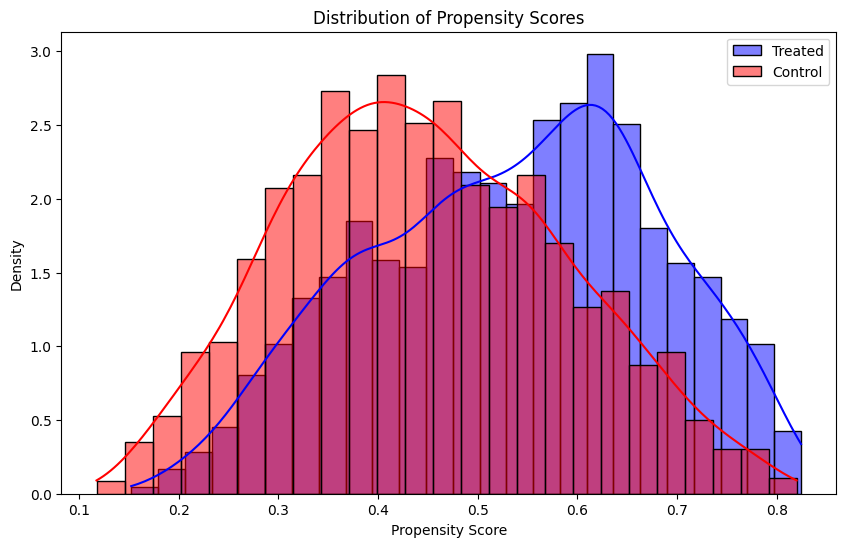

             Covariate  Mean_Treated  Mean_Control  SMD_Before  SMD_After  \
0               ALQ121      0.148313      0.117791    0.089958   0.011471   
1  unhealthy_condition      0.936983      0.920245    0.065042   0.094126   
2             INDFMIN2      9.665181      7.826994    0.422332   0.068899   
3             RIAGENDR      0.943348      1.007362   -0.064066   0.032800   
4       RIDAGEYR_fixed     48.226607     53.942331   -0.335919   0.083862   
5               SLD012      7.558880      7.491411    0.041376   0.105915   
6              BPXPULS      0.024825      0.046626   -0.117661   0.006858   
7            Sys_AVEBP    123.196266    128.048262   -0.263712   0.111507   
8               BMXBMI     29.126034     30.531472   -0.199102   0.100200   
9           smoker_con      0.222788      0.296933   -0.169672   0.017341   

   p-value_Before  p-value_After  
0    1.094751e-02       0.745995  
1    6.626820e-02       0.007812  
2    3.234842e-32       0.052852  
3    7.01657

In [ ]:
## Check overlap assumption
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Add the propensity scores to the original DataFrame
df1_no_na['propensity_score'] = propensity_scores
df1_no_na['weights'] = np.where(df1_no_na['exercise'] == 1, weights_treatment, weights_control)

# Plot the distribution of propensity scores
plt.figure(figsize=(10, 6))
sns.histplot(df1_no_na[df1_no_na['exercise'] == 1]['propensity_score'], label='Treated', color='blue', kde=True, stat="density", bins=25)
sns.histplot(df1_no_na[df1_no_na['exercise'] == 0]['propensity_score'], label='Control', color='red', kde=True, stat="density", bins=25)
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores')
plt.legend()
plt.show()

# Function to calculate standardized mean difference
def standardized_mean_difference(group1, group2):
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1)**2 + np.std(group2)**2) / 2)
    return mean_diff / pooled_std

# Check covariate balance before and after weighting
covariate_columns = covariates.columns
balance_data = []

for covariate in covariate_columns:
    treated_group = df1_no_na[df1_no_na['exercise'] == 1][covariate]
    control_group = df1_no_na[df1_no_na['exercise'] == 0][covariate]

    # Calculate means before weighting
    mean_treated_before = np.mean(treated_group)
    mean_control_before = np.mean(control_group)

    # Calculate SMD before weighting
    smd_before = standardized_mean_difference(treated_group, control_group)

    # Calculate t-test before weighting
    t_stat_before, p_val_before = ttest_ind(treated_group, control_group)

    # Calculate means after weighting
    mean_treated_after = np.average(df1_no_na[df1_no_na['exercise'] == 1][covariate], weights=df1_no_na[df1_no_na['exercise'] == 1]['weights'])
    mean_control_after = np.average(df1_no_na[df1_no_na['exercise'] == 0][covariate], weights=df1_no_na[df1_no_na['exercise'] == 0]['weights'])

    # Calculate SMD after weighting
    smd_after = standardized_mean_difference(
        df1_no_na[df1_no_na['exercise'] == 1][covariate] * df1_no_na[df1_no_na['exercise'] == 1]['weights'],
        df1_no_na[df1_no_na['exercise'] == 0][covariate] * df1_no_na[df1_no_na['exercise'] == 0]['weights']
    )

    # Calculate t-test after weighting
    t_stat_after, p_val_after = ttest_ind(
        df1_no_na[df1_no_na['exercise'] == 1][covariate] * df1_no_na[df1_no_na['exercise'] == 1]['weights'],
        df1_no_na[df1_no_na['exercise'] == 0][covariate] * df1_no_na[df1_no_na['exercise'] == 0]['weights']
    )

    # Append to balance data
    balance_data.append({
        'Covariate': covariate,
        'Mean_Treated': mean_treated_before,
        'Mean_Control': mean_control_before,
        'SMD_Before': smd_before,
        'SMD_After': smd_after,
        'p-value_Before': p_val_before,
        'p-value_After': p_val_after
    })

balance_table = pd.DataFrame(balance_data)

print(balance_table)

print(df1_no_na.sort_values(by='propensity_score', ascending=True))

####Method 4.AIPWE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# Assuming df1_no_na is your DataFrame

# Define treatment and covariates
X = df1_no_na[['exercise', 'ALQ121', 'unhealthy_condition', 'INDFMIN2', 'RIAGENDR', 'RIDAGEYR_fixed', 'SLD012', 'BPXPULS', 'Sys_AVEBP', 'BMXBMI', 'smoker_con']]
y = df1_no_na['DIQ010']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['exercise']
covariates = X.drop(columns=['exercise'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Calculate Weights
weights_treatment = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

# Filter the weights to match the corresponding treatment and control groups
weights_treatment_filtered = weights_treatment[treatment == 1]
weights_control_filtered = weights_control[treatment == 0]

# Step 3: Estimate ATE using the average of weighted outcomes method
# Weighted outcomes for treatment and control groups
weighted_outcome_treatment = np.sum(weights_treatment_filtered * y[treatment == 1]) / np.sum(weights_treatment_filtered)
weighted_outcome_control = np.sum(weights_control_filtered * y[treatment == 0]) / np.sum(weights_control_filtered)

# Calculate ATE
ate_ipw = weighted_outcome_treatment - weighted_outcome_control

# Calculate standard errors for IPW
# Compute the weighted residuals
residuals_treatment = weights_treatment_filtered * (y[treatment == 1] - weighted_outcome_treatment)
residuals_control = weights_control_filtered * (y[treatment == 0] - weighted_outcome_control)

# Variance of ATE
variance_ate_ipw = (np.sum(residuals_treatment ** 2) / (np.sum(weights_treatment_filtered) ** 2)) + (np.sum(residuals_control ** 2) / (np.sum(weights_control_filtered) ** 2))

# Standard error of ATE
ate_ipw_se = np.sqrt(variance_ate_ipw)

# Step 4: Doubly Robust Estimation
# Fit outcome regression models
outcome_model_treated = LogisticRegression().fit(covariates[treatment == 1], y[treatment == 1])
outcome_model_control = LogisticRegression().fit(covariates[treatment == 0], y[treatment == 0])

# Predict outcomes
y_hat_treated = outcome_model_treated.predict(covariates)
y_hat_control = outcome_model_control.predict(covariates)

# Calculate the doubly robust estimates
dr_estimate_treated = y_hat_treated + (treatment / propensity_scores) * (y - y_hat_treated)
dr_estimate_control = y_hat_control + ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Calculate ATE using doubly robust estimates
ate_dr = np.mean(dr_estimate_treated - dr_estimate_control)

# Calculate standard errors for DR
# Residuals for DR
residuals_dr_treated = (treatment / propensity_scores) * (y - y_hat_treated)
residuals_dr_control = ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Variance of ATE for DR
variance_ate_dr = np.var(dr_estimate_treated - dr_estimate_control) / len(y)

# Standard error of ATE for DR
ate_dr_se = np.sqrt(variance_ate_dr)

print(f"The estimated Average Treatment Effect (ATE) using Doubly Robust method is: {ate_dr}")
print(f"The standard error of the ATE estimate using Doubly Robust method is: {ate_dr_se}")

The estimated Average Treatment Effect (ATE) using Doubly Robust method is: -0.030944577808572727
The standard error of the ATE estimate using Doubly Robust method is: 0.015618628125673592


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

####Method 5.Double Robust PLM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Assuming df1_no_na is your DataFrame

# Define treatment and covariates
X = df1_no_na[['exercise', 'ALQ121', 'unhealthy_condition', 'INDFMIN2', 'RIAGENDR', 'RIDAGEYR_fixed', 'SLD012', 'BPXPULS', 'Sys_AVEBP', 'BMXBMI', 'smoker_con']]
y = df1_no_na['DIQ010']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['exercise']
covariates = X.drop(columns=['exercise'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Outcome Regression using Partially Linear Model (PLM)
# Fit outcome regression models using a flexible model like RandomForestRegressor
outcome_model_treated = RandomForestRegressor(n_estimators=100, random_state=0).fit(covariates[treatment == 1], y[treatment == 1])
outcome_model_control = RandomForestRegressor(n_estimators=100, random_state=0).fit(covariates[treatment == 0], y[treatment == 0])


# Predict outcomes
y_hat_treated = outcome_model_treated.predict(covariates)
y_hat_control = outcome_model_control.predict(covariates)

# Calculate the doubly robust estimates
dr_estimate_treated = y_hat_treated + (treatment / propensity_scores) * (y - y_hat_treated)
dr_estimate_control = y_hat_control + ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Calculate ATE using doubly robust PLM estimates
ate_dr_plm = np.mean(dr_estimate_treated - dr_estimate_control)

# Calculate standard errors for DR PLM
# Residuals for DR PLM
residuals_dr_treated = (treatment / propensity_scores) * (y - y_hat_treated)
residuals_dr_control = ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Variance of ATE for DR PLM
variance_ate_dr_plm = np.var(dr_estimate_treated - dr_estimate_control) / len(y)

# Standard error of ATE for DR PLM
ate_dr_plm_se = np.sqrt(variance_ate_dr_plm)

print(f"The estimated Average Treatment Effect (ATE) using Doubly Robust PLM method is: {ate_dr_plm}")
print(f"The standard error of the ATE estimate using Doubly Robust PLM method is: {ate_dr_plm_se}")

The estimated Average Treatment Effect (ATE) using Doubly Robust PLM method is: -0.030098768074424184
The standard error of the ATE estimate using Doubly Robust PLM method is: 0.009172871906457802


### Hypothesis 2 DIQ010 ~ 'BMI_above_30'

#### Method 1.Regression-Based w/o interactions

In [ ]:
##
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

df1_no_na = df1[['DIQ010', 'BMI_above_30','exercise', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP','smoker_con']].dropna()
df1_no_na = df1_no_na[df1_no_na['RIDAGEYR_fixed'] >= 21]


X = df1_no_na[['BMI_above_30','exercise', 'unhealthy_condition', 'ALQ121','INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'smoker_con']]
y = df1_no_na['DIQ010']
x_categorical_name_list = []
X = pd.get_dummies(X, columns=x_categorical_name_list, drop_first=True)
transformed_columns = [col for col in X.columns if any(prefix in col for prefix in x_categorical_name_list)]
X[transformed_columns] = X[transformed_columns].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

def ATE_est_reg(X_train, X_test, y_train, y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model_ate = sm.Logit(y_train, X_train).fit(cov_type='HC1')
    ate_summary = model_ate.summary()
    print(ate_summary)

    # Predict probabilities on the test set
    y_pred_prob = model_ate.predict(X_test)

    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f'AUC: {auc}')
    return


ATE_est_reg(X_train, X_test, y_train, y_test)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# Assuming df1 is your dataframe and it is already loaded
df1_no_na = df1[['DIQ010', 'BMI_above_30', 'exercise', 'unhealthy_condition', 'ALQ121', 'INDFMIN2', 'RIAGENDR', 'RIDAGEYR_fixed', 'SLD012', 'BPXPULS', 'Sys_AVEBP', 'smoker_con']].dropna()
df1_no_na = df1_no_na[df1_no_na['RIDAGEYR_fixed'] >= 21]

X = df1_no_na[['exercise', 'unhealthy_condition', 'ALQ121', 'INDFMIN2', 'RIAGENDR', 'RIDAGEYR_fixed', 'SLD012', 'BPXPULS', 'Sys_AVEBP', 'smoker_con']]
y = df1_no_na['DIQ010']
treatment = df1_no_na['BMI_above_30']

# Assuming no categorical columns need one-hot encoding
x_categorical_name_list = []
X = pd.get_dummies(X, columns=x_categorical_name_list, drop_first=True)
transformed_columns = [col for col in X.columns if any(prefix in col for prefix in x_categorical_name_list)]
X[transformed_columns] = X[transformed_columns].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(X, y, treatment, test_size=0.2, random_state=66)

def bootstrap_ate_auc(model, X_train, X_test, y_train, y_test, treatment_train, n_bootstraps=1000):
    ate_values = []
    auc_values = []

    for _ in range(n_bootstraps):
        X_resampled, y_resampled, treatment_resampled = resample(X_train, y_train, treatment_train)
        model.fit(X_resampled, y_resampled)

        if hasattr(model, 'predict_proba'):
            y_pred_prob = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_prob = model.predict(X_test)
            y_pred_prob = (y_pred_prob > 0.5).astype(int)  # Binarize the predictions

        # Calculate ATE based on the treatment
        ate = np.mean(y_pred_prob[treatment_test == 1]) - np.mean(y_pred_prob[treatment_test == 0])
        ate_values.append(ate)

        # Calculate AUC
        auc = roc_auc_score(y_test, y_pred_prob)
        auc_values.append(auc)

    ate_mean = np.mean(ate_values)
    ate_se = np.std(ate_values, ddof=1)
    auc_mean = np.mean(auc_values)

    return ate_mean, ate_se, auc_mean

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
ate_log_reg, se_log_reg, auc_log_reg = bootstrap_ate_auc(log_reg, X_train, X_test, y_train, y_test, treatment_train)
print(f'Logistic Regression - ATE: {ate_log_reg}, SE: {se_log_reg}, AUC: {auc_log_reg}')

# Lasso Regression
lasso = Lasso(alpha=0.1)
ate_lasso, se_lasso, auc_lasso = bootstrap_ate_auc(lasso, X_train, X_test, y_train, y_test, treatment_train)
print(f'Lasso Regression - ATE: {ate_lasso}, SE: {se_lasso}, AUC: {auc_lasso}')

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=66)
ate_rf_clf, se_rf_clf, auc_rf_clf = bootstrap_ate_auc(rf_clf, X_train, X_test, y_train, y_test, treatment_train)
print(f'Random Forest Classifier - ATE: {ate_rf_clf}, SE: {se_rf_clf}, AUC: {auc_rf_clf}')

# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=66)
ate_dt_clf, se_dt_clf, auc_dt_clf = bootstrap_ate_auc(dt_clf, X_train, X_test, y_train, y_test, treatment_train)
print(f'Decision Tree Classifier - ATE: {ate_dt_clf}, SE: {se_dt_clf}, AUC: {auc_dt_clf}')

####Method 2.Regression-Based w/ interactions

In [ ]:
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import roc_auc_score
from itertools import combinations

def ATE_est_reg_interaction(X_train, X_test, y_train, y_test):
    # Add constant term to the features
    cols_to_subtract_mean = X_train.columns[X_train.columns != 'BMI_above_30']
    X_train[cols_to_subtract_mean] = X_train[cols_to_subtract_mean] - X_train[cols_to_subtract_mean].mean()
    X_test[cols_to_subtract_mean] = X_test[cols_to_subtract_mean] - X_test[cols_to_subtract_mean].mean()
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Create pairwise interaction terms for X_train
    interaction_terms_train = pd.DataFrame(index=X_train.index)
    interaction_terms_test = pd.DataFrame(index=X_test.index)

    # Get the list of feature names excluding the constant term
    feature_names = X_train.columns[1:]

    # Generate interaction terms
    for (i, j) in combinations(feature_names, 2):
        interaction_terms_train[f'{i}:{j}'] = X_train[i] * X_train[j]
        interaction_terms_test[f'{i}:{j}'] = X_test[i] * X_test[j]

    # Combine the original features with the interaction terms
    X_train_inter = pd.concat([X_train, interaction_terms_train], axis=1)
    X_test_inter = pd.concat([X_test, interaction_terms_test], axis=1)

    # Fit the logistic regression model
    model_ate = sm.Logit(y_train, X_train_inter).fit(cov_type='HC1')
    ate_summary = model_ate.summary()
    print(ate_summary)

    # Predict probabilities on the test set
    y_pred_prob = model_ate.predict(X_test_inter)

    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f'AUC: {auc}')
    return

ATE_est_reg_interaction(X_train, X_test, y_train, y_test)


In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
from sklearn.metrics import roc_auc_score

def ATE_est_reg_interaction_lasso_cv(X_train, X_test, y_train, y_test, alphas=np.logspace(-4, 2, 10), cv=5):
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create pairwise interaction terms for X_train
    interaction_terms_train = pd.DataFrame(index=X_train.index)
    interaction_terms_test = pd.DataFrame(index=X_test.index)

    # Get the list of feature names
    feature_names = X_train.columns

    # Generate interaction terms
    for (i, j) in combinations(feature_names, 2):
        interaction_terms_train[f'{i}:{j}'] = X_train[i] * X_train[j]
        interaction_terms_test[f'{i}:{j}'] = X_test[i] * X_test[j]

    # Combine the original features with the interaction terms
    X_train_inter = pd.concat([X_train, interaction_terms_train], axis=1)
    X_test_inter = pd.concat([X_test, interaction_terms_test], axis=1)

    # Fit Logistic Regression with Lasso (L1) regularization and cross-validation
    model_ate = LogisticRegressionCV(Cs=alphas, cv=cv, penalty='l1', solver='liblinear', scoring='roc_auc')
    model_ate.fit(X_train_inter, y_train)

    # Print selected features
    selected_features = X_train_inter.columns[model_ate.coef_[0] != 0]
    print("Selected Features:", selected_features)

    # Extract coefficients and standard errors
    coef = model_ate.coef_[0]
    coef_std_err = np.std([model_ate.coef_[i] for i in range(len(model_ate.coef_))], axis=0)

    # Create a DataFrame to store results
    results = pd.DataFrame(index=X_train_inter.columns)
    results['Coefficient'] = coef
    results['Standard Error'] = coef_std_err

    # Calculate p-values using statsmodels Logit
    X_train_inter_sm = sm.add_constant(X_train_inter)
    logit_model = sm.Logit(y_train, X_train_inter_sm)
    result = logit_model.fit(disp=0)
    p_values = result.pvalues.drop('const')

    # Add p-values to the results DataFrame
    results['P-value'] = p_values

    # Print formatted table
    print("Results:")
    print(results.to_string(formatters={'Coefficient': '{:.4f}'.format,
                                         'Standard Error': '{:.4f}'.format,
                                         'P-value': '{:.4f}'.format}))

    # Predict probabilities on the test set
    y_pred_prob = model_ate.predict_proba(X_test_inter)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f'AUC: {auc}')

    return model_ate

# Example usage:
model_ate_lasso_cv = ATE_est_reg_interaction_lasso_cv(X_train, X_test, y_train, y_test)


####Method 3.IPWE

In [ ]:
#propensity method

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# Assuming df1_no_na is your DataFrame

# Define treatment and covariates
X = df1_no_na[['BMI_above_30','exercise', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP','smoker_con']]
y = df1_no_na['DIQ010']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['BMI_above_30']
covariates = X.drop(columns=['BMI_above_30'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Calculate Weights
weights_treatment = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

# Step 3: Estimate ATE using the average of weighted outcomes method
# Filter the weights to match the corresponding treatment and control groups
weights_treatment_filtered = weights_treatment[treatment == 1]
weights_control_filtered = weights_control[treatment == 0]

# Weighted outcomes for treatment and control groups
weighted_outcome_treatment = np.sum(weights_treatment_filtered * y[treatment == 1]) / np.sum(weights_treatment_filtered)
weighted_outcome_control = np.sum(weights_control_filtered * y[treatment == 0]) / np.sum(weights_control_filtered)

# Calculate ATE
ate = weighted_outcome_treatment - weighted_outcome_control

# Calculate standard errors
# Compute the weighted residuals
residuals_treatment = weights_treatment_filtered * (y[treatment == 1] - weighted_outcome_treatment)
residuals_control = weights_control_filtered * (y[treatment == 0] - weighted_outcome_control)

# Variance of ATE
variance_ate = (np.sum(residuals_treatment ** 2) / (np.sum(weights_treatment_filtered) ** 2)) + (np.sum(residuals_control ** 2) / (np.sum(weights_control_filtered) ** 2))

# Standard error of ATE
ate_se = np.sqrt(variance_ate)

print(f"The estimated Average Treatment Effect (ATE) is: {ate}")
print(f"The standard error of the ATE estimate is: {ate_se}")


In [ ]:
#Check Overlap Assumption and Covariate Balance
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Add the propensity scores to the original DataFrame
df1_no_na['propensity_score'] = propensity_scores
df1_no_na['weights'] = np.where(df1_no_na['BMI_above_30'] == 1, weights_treatment, weights_control)

# Plot the distribution of propensity scores
plt.figure(figsize=(10, 6))
sns.histplot(df1_no_na[df1_no_na['BMI_above_30'] == 1]['propensity_score'], label='Treated', color='blue', kde=True, stat="density", bins=25)
sns.histplot(df1_no_na[df1_no_na['BMI_above_30'] == 0]['propensity_score'], label='Control', color='red', kde=True, stat="density", bins=25)
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores')
plt.legend()
plt.show()

# Function to calculate standardized mean difference
def standardized_mean_difference(group1, group2):
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1)**2 + np.std(group2)**2) / 2)
    return mean_diff / pooled_std

# Check covariate balance before and after weighting
covariate_columns = covariates.columns
balance_data = []

for covariate in covariate_columns:
    treated_group = df1_no_na[df1_no_na['BMI_above_30'] == 1][covariate]
    control_group = df1_no_na[df1_no_na['BMI_above_30'] == 0][covariate]

    # Calculate means before weighting
    mean_treated_before = np.mean(treated_group)
    mean_control_before = np.mean(control_group)

    # Calculate SMD before weighting
    smd_before = standardized_mean_difference(treated_group, control_group)

    # Calculate t-test before weighting
    t_stat_before, p_val_before = ttest_ind(treated_group, control_group)

    # Calculate means after weighting
    mean_treated_after = np.average(df1_no_na[df1_no_na['BMI_above_30'] == 1][covariate], weights=df1_no_na[df1_no_na['BMI_above_30'] == 1]['weights'])
    mean_control_after = np.average(df1_no_na[df1_no_na['BMI_above_30'] == 0][covariate], weights=df1_no_na[df1_no_na['BMI_above_30'] == 0]['weights'])

    # Calculate SMD after weighting
    smd_after = standardized_mean_difference(
        df1_no_na[df1_no_na['BMI_above_30'] == 1][covariate] * df1_no_na[df1_no_na['BMI_above_30'] == 1]['weights'],
        df1_no_na[df1_no_na['BMI_above_30'] == 0][covariate] * df1_no_na[df1_no_na['BMI_above_30'] == 0]['weights']
    )

    # Calculate t-test after weighting
    t_stat_after, p_val_after = ttest_ind(
        df1_no_na[df1_no_na['BMI_above_30'] == 1][covariate] * df1_no_na[df1_no_na['BMI_above_30'] == 1]['weights'],
        df1_no_na[df1_no_na['BMI_above_30'] == 0][covariate] * df1_no_na[df1_no_na['BMI_above_30'] == 0]['weights']
    )

    # Append to balance data
    balance_data.append({
        'Covariate': covariate,
        'Mean_Treated': mean_treated_before,
        'Mean_Control': mean_control_before,
        'SMD_Before': smd_before,
        'SMD_After': smd_after,
        'p-value_Before': p_val_before,
        'p-value_After': p_val_after
    })

balance_table = pd.DataFrame(balance_data)

print(balance_table)

print(df1_no_na.sort_values(by='propensity_score', ascending=True))


####Method 4.AIPWE

In [ ]:
#OLS
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# Assuming df1_no_na is your DataFrame

# Define treatment and covariates
X = df1_no_na[['BMI_above_30','exercise', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP','smoker_con']]
y = df1_no_na['DIQ010']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['BMI_above_30']
covariates = X.drop(columns=['BMI_above_30'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Calculate Weights
weights_treatment = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

# Filter the weights to match the corresponding treatment and control groups
weights_treatment_filtered = weights_treatment[treatment == 1]
weights_control_filtered = weights_control[treatment == 0]

# Step 3: Estimate ATE using the average of weighted outcomes method
# Weighted outcomes for treatment and control groups
weighted_outcome_treatment = np.sum(weights_treatment_filtered * y[treatment == 1]) / np.sum(weights_treatment_filtered)
weighted_outcome_control = np.sum(weights_control_filtered * y[treatment == 0]) / np.sum(weights_control_filtered)

# Calculate ATE
ate_ipw = weighted_outcome_treatment - weighted_outcome_control

# Calculate standard errors for IPW
# Compute the weighted residuals
residuals_treatment = weights_treatment_filtered * (y[treatment == 1] - weighted_outcome_treatment)
residuals_control = weights_control_filtered * (y[treatment == 0] - weighted_outcome_control)

# Variance of ATE
variance_ate_ipw = (np.sum(residuals_treatment ** 2) / (np.sum(weights_treatment_filtered) ** 2)) + (np.sum(residuals_control ** 2) / (np.sum(weights_control_filtered) ** 2))

# Standard error of ATE
ate_ipw_se = np.sqrt(variance_ate_ipw)

# Step 4: Doubly Robust Estimation
# Fit outcome regression models
outcome_model_treated = LinearRegression().fit(covariates[treatment == 1], y[treatment == 1])
outcome_model_control = LinearRegression().fit(covariates[treatment == 0], y[treatment == 0])

# Predict outcomes
y_hat_treated = outcome_model_treated.predict(covariates)
y_hat_control = outcome_model_control.predict(covariates)

# Calculate the doubly robust estimates
dr_estimate_treated = y_hat_treated + (treatment / propensity_scores) * (y - y_hat_treated)
dr_estimate_control = y_hat_control + ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Calculate ATE using doubly robust estimates
ate_dr = np.mean(dr_estimate_treated - dr_estimate_control)

# Calculate standard errors for DR
# Residuals for DR
residuals_dr_treated = (treatment / propensity_scores) * (y - y_hat_treated)
residuals_dr_control = ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Variance of ATE for DR
variance_ate_dr = np.var(dr_estimate_treated - dr_estimate_control) / len(y)

# Standard error of ATE for DR
ate_dr_se = np.sqrt(variance_ate_dr)

print(f"The estimated Average Treatment Effect (ATE) using IPW is: {ate_ipw}")
print(f"The standard error of the ATE estimate using IPW is: {ate_ipw_se}")
print(f"The estimated Average Treatment Effect (ATE) using Doubly Robust method is: {ate_dr}")
print(f"The standard error of the ATE estimate using Doubly Robust method is: {ate_dr_se}")


In [ ]:
#GradientBoosting
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

# Assuming df1_no_na is your DataFrame

# Define treatment and covariates
X = df1_no_na[['BMI_above_30','exercise', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP','smoker_con']]
y = df1_no_na['DIQ010']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['BMI_above_30']
covariates = X.drop(columns=['BMI_above_30'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Calculate Weights
weights_treatment = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

# Filter the weights to match the corresponding treatment and control groups
weights_treatment_filtered = weights_treatment[treatment == 1]
weights_control_filtered = weights_control[treatment == 0]

# Step 3: Estimate ATE using the average of weighted outcomes method
# Weighted outcomes for treatment and control groups
weighted_outcome_treatment = np.sum(weights_treatment_filtered * y[treatment == 1]) / np.sum(weights_treatment_filtered)
weighted_outcome_control = np.sum(weights_control_filtered * y[treatment == 0]) / np.sum(weights_control_filtered)

# Calculate ATE
ate_ipw = weighted_outcome_treatment - weighted_outcome_control

# Calculate standard errors for IPW
# Compute the weighted residuals
residuals_treatment = weights_treatment_filtered * (y[treatment == 1] - weighted_outcome_treatment)
residuals_control = weights_control_filtered * (y[treatment == 0] - weighted_outcome_control)

# Variance of ATE
variance_ate_ipw = (np.sum(residuals_treatment ** 2) / (np.sum(weights_treatment_filtered) ** 2)) + (np.sum(residuals_control ** 2) / (np.sum(weights_control_filtered) ** 2))

# Standard error of ATE
ate_ipw_se = np.sqrt(variance_ate_ipw)

# Step 4: Doubly Robust Estimation
# Fit outcome regression models using Gradient Boosting Regressor
outcome_model_treated = GradientBoostingRegressor().fit(covariates[treatment == 1], y[treatment == 1])
outcome_model_control = GradientBoostingRegressor().fit(covariates[treatment == 0], y[treatment == 0])

# Predict outcomes
y_hat_treated = outcome_model_treated.predict(covariates)
y_hat_control = outcome_model_control.predict(covariates)

# Calculate the doubly robust estimates
dr_estimate_treated = y_hat_treated + (treatment / propensity_scores) * (y - y_hat_treated)
dr_estimate_control = y_hat_control + ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Calculate ATE using doubly robust estimates
ate_dr = np.mean(dr_estimate_treated - dr_estimate_control)

# Calculate standard errors for DR
# Residuals for DR
residuals_dr_treated = (treatment / propensity_scores) * (y - y_hat_treated)
residuals_dr_control = ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Variance of ATE for DR
variance_ate_dr = np.var(dr_estimate_treated - dr_estimate_control) / len(y)

# Standard error of ATE for DR
ate_dr_se = np.sqrt(variance_ate_dr)

print(f"The estimated Average Treatment Effect (ATE) using IPW is: {ate_ipw}")
print(f"The standard error of the ATE estimate using IPW is: {ate_ipw_se}")
print(f"The estimated Average Treatment Effect (ATE) using Doubly Robust method is: {ate_dr}")
print(f"The standard error of the ATE estimate using Doubly Robust method is: {ate_dr_se}")

####Method 5.Double Robust PLM

In [ ]:
#Random Forest
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

# Assuming df1_no_na is your DataFrame

# Define treatment and covariates
X = df1_no_na[['BMI_above_30', 'exercise', 'unhealthy_condition', 'ALQ121', 'INDFMIN2', 'RIAGENDR', 'RIDAGEYR_fixed', 'SLD012', 'BPXPULS', 'Sys_AVEBP', 'smoker_con']]
y = df1_no_na['DIQ010']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['BMI_above_30']
covariates = X.drop(columns=['BMI_above_30'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Outcome Regression using Random Forest Regressor
# Fit outcome regression models using Random Forest Regressor
outcome_model_treated = RandomForestRegressor().fit(covariates[treatment == 1], y[treatment == 1])
outcome_model_control = RandomForestRegressor().fit(covariates[treatment == 0], y[treatment == 0])

# Predict outcomes
y_hat_treated = outcome_model_treated.predict(covariates)
y_hat_control = outcome_model_control.predict(covariates)

# Calculate the doubly robust estimates
dr_estimate_treated = y_hat_treated + (treatment / propensity_scores) * (y - y_hat_treated)
dr_estimate_control = y_hat_control + ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Calculate ATE using doubly robust Random Forest estimates
ate_dr_rf = np.mean(dr_estimate_treated - dr_estimate_control)

# Calculate standard errors for DR Random Forest
# Residuals for DR Random Forest
residuals_dr_treated = (treatment / propensity_scores) * (y - y_hat_treated)
residuals_dr_control = ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Variance of ATE for DR Random Forest
variance_ate_dr_rf = np.var(dr_estimate_treated - dr_estimate_control) / len(y)

# Standard error of ATE for DR Random Forest
ate_dr_rf_se = np.sqrt(variance_ate_dr_rf)

print(f"The estimated Average Treatment Effect (ATE) using Doubly Robust Random Forest method is: {ate_dr_rf}")
print(f"The standard error of the ATE estimate using Doubly Robust Random Forest method is: {ate_dr_rf_se}")

## Topic 2. Hypertension



###Hypothesis 1 LBDHDD ~ 'BMI_above_30'

LBDHDD ~ 'BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con'

####Method 1.Regression-based w/o interactions

In [ ]:
##OLS

import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Assuming df1 is already defined and cleaned
df1_no_na = df1[['LBDHDD', 'BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con']].dropna()

X = df1_no_na[['BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con']]
y = df1_no_na['LBDHDD']
x_categorical_name_list = []
X = pd.get_dummies(X, columns=x_categorical_name_list, drop_first=True)
transformed_columns = [col for col in X.columns if any(prefix in col for prefix in x_categorical_name_list)]
X[transformed_columns] = X[transformed_columns].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

# Calculate the number of observations in training and test datasets
num_train_obs = len(X_train)
num_test_obs = len(X_test)
total_obs = num_train_obs + num_test_obs

print(f'Number of observations in training dataset: {num_train_obs}')
print(f'Number of observations in test dataset: {num_test_obs}')
print(f'Total number of observations: {total_obs}')

def ATE_est_reg(X_train, X_test, y_train, y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model_ate = sm.OLS(y_train, X_train).fit(cov_type='HC1')  # Fit OLS model
    ate_summary = model_ate.summary()
    print(ate_summary)

    # Predict probabilities on the test set
    y_pred = model_ate.predict(X_test)

    # Calculate R-squared and MSE
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f'R-squared: {r2}, MSE: {mse}')
    return

ATE_est_reg(X_train, X_test, y_train, y_test)

Number of observations in training dataset: 2695
Number of observations in test dataset: 674
Total number of observations: 3369
                            OLS Regression Results                            
Dep. Variable:                 LBDHDD   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     88.48
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          3.91e-184
Time:                        02:56:49   Log-Likelihood:                -10802.
No. Observations:                2695   AIC:                         2.163e+04
Df Residuals:                    2682   BIC:                         2.171e+04
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0

In [ ]:
##Lasso

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample
from scipy.stats import norm

# Assuming df1 is your dataframe
df1_no_na = df1[['LBDHDD', 'BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con']].dropna()

X = df1_no_na[['BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con']]
y = df1_no_na['LBDHDD']
x_categorical_name_list = []
X = pd.get_dummies(X, columns=x_categorical_name_list, drop_first=True)
transformed_columns = [col for col in X.columns if any(prefix in col for prefix in x_categorical_name_list)]
X[transformed_columns] = X[transformed_columns].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

def bootstrap_lasso(X_train, y_train, n_iterations=1000, alpha=1.0):
    coefficients = np.zeros((n_iterations, X_train.shape[1]))

    for i in range(n_iterations):
        # Bootstrap sample
        X_resampled, y_resampled = resample(X_train, y_train, random_state=i)

        model_lasso = Lasso(alpha=alpha, random_state=66)
        model_lasso.fit(X_resampled, y_resampled)

        # Store coefficients
        coefficients[i, :] = model_lasso.coef_

    # Calculate mean and standard error of coefficients
    mean_coefficients = np.mean(coefficients, axis=0)
    std_coefficients = np.std(coefficients, axis=0)

    return mean_coefficients, std_coefficients

mean_coefficients, std_coefficients = bootstrap_lasso(X_train, y_train)

# Create a summary table
summary_table = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean Coefficient': mean_coefficients,
    'Standard Error': std_coefficients
})

# Calculate z-scores and p-values
summary_table['Z-Score'] = summary_table['Mean Coefficient'] / summary_table['Standard Error']
summary_table['P-Value'] = norm.sf(abs(summary_table['Z-Score'])) * 2  # Two-tailed test

# Mark significant features
alpha = 0.05  # Significance level
summary_table['Significant'] = summary_table['P-Value'] < alpha

print(summary_table)

# Fit final model and evaluate
model_lasso = Lasso(alpha=1.0, random_state=66)
model_lasso.fit(X_train, y_train)
y_pred = model_lasso.predict(X_test)

# Calculate R-squared and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'R-squared: {r2}, MSE: {mse}')

                Feature  Mean Coefficient  Standard Error    Z-Score  \
0          BMI_above_30         -4.085781        0.544460  -7.504283   
1   unhealthy_condition          0.000000        0.000000        NaN   
2                ALQ121          0.459034        0.679475   0.675571   
3              INDFMIN2          0.089334        0.057099   1.564533   
4              RIAGENDR          4.145636        0.272856  15.193467   
5        RIDAGEYR_fixed          0.076568        0.015072   5.080044   
6                SLD012          0.009570        0.036235   0.264111   
7               BPXPULS          0.000000        0.000000        NaN   
8             Sys_AVEBP         -0.006684        0.014901  -0.448574   
9              exercise          0.000148        0.004686   0.031639   
10             WH_ratio          0.000000        0.000000        NaN   
11           smoker_con          0.000000        0.000000        NaN   

         P-Value  Significant  
0   6.176578e-14         True  

In [ ]:
##Random Forest
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Assuming df1 is your dataframe
df1_no_na = df1[['LBDHDD', 'BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con']].dropna()

X = df1_no_na[['BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con']]
y = df1_no_na['LBDHDD']
x_categorical_name_list = []
X = pd.get_dummies(X, columns=x_categorical_name_list, drop_first=True)
transformed_columns = [col for col in X.columns if any(prefix in col for prefix in x_categorical_name_list)]
X[transformed_columns] = X[transformed_columns].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

def ATE_est_rf(X_train, X_test, y_train, y_test):
    model_rf = RandomForestRegressor(n_estimators=100, random_state=66)
    model_rf.fit(X_train, y_train)


    # Predict on the test set
    y_pred = model_rf.predict(X_test)

    # Calculate R-squared and MSE
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f'R-squared: {r2}, MSE: {mse}')

    # Feature importance
    feature_importances = model_rf.feature_importances_
    for feature, importance in zip(X_train.columns, feature_importances):
        print(f'{feature}: {importance}')

    return

ATE_est_rf(X_train, X_test, y_train, y_test)


R-squared: 0.21585690260180068, MSE: 188.16585519287833
BMI_above_30: 0.04683387089244997
unhealthy_condition: 0.013052845360605464
ALQ121: 0.04512761560097355
INDFMIN2: 0.08502083470130889
RIAGENDR: 0.07425331717145878
RIDAGEYR_fixed: 0.15563438907095203
SLD012: 0.10877742169065394
BPXPULS: 0.008612495760827649
Sys_AVEBP: 0.14954264485092608
exercise: 0.019388341115730446
WH_ratio: 0.2716627708311699
smoker_con: 0.022093452952943418


In [ ]:
##Gradient Boosting
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Assuming df1 is your dataframe
df1_no_na = df1[['LBDHDD', 'BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con']].dropna()

X = df1_no_na[['BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con']]
y = df1_no_na['LBDHDD']
x_categorical_name_list = []
X = pd.get_dummies(X, columns=x_categorical_name_list, drop_first=True)
transformed_columns = [col for col in X.columns if any(prefix in col for prefix in x_categorical_name_list)]
X[transformed_columns] = X[transformed_columns].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

def ATE_est_gb(X_train, X_test, y_train, y_test):
    model_gb = GradientBoostingRegressor(n_estimators=100, random_state=66)
    model_gb.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model_gb.predict(X_test)

    # Calculate R-squared and MSE
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f'R-squared: {r2}, MSE: {mse}')

    # Feature importance
    feature_importances = model_gb.feature_importances_
    for feature, importance in zip(X_train.columns, feature_importances):
        print(f'{feature}: {importance}')

    return

ATE_est_gb(X_train, X_test, y_train, y_test)

R-squared: 0.22412618215024127, MSE: 186.18152852696224
BMI_above_30: 0.10232193535648453
unhealthy_condition: 0.00436900416333798
ALQ121: 0.10613257718476135
INDFMIN2: 0.024819286535453573
RIAGENDR: 0.1539211822652936
RIDAGEYR_fixed: 0.13343311437852243
SLD012: 0.06128470359497054
BPXPULS: 0.0011117492584692998
Sys_AVEBP: 0.07272005681931058
exercise: 0.003937923317167971
WH_ratio: 0.32411925454313134
smoker_con: 0.011829212583096856


In [ ]:
##ANN

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Assuming df1 is your dataframe
df1_no_na = df1[['LBDHDD', 'BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con']].dropna()

X = df1_no_na[['BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con']]
y = df1_no_na['LBDHDD']
x_categorical_name_list = []
X = pd.get_dummies(X, columns=x_categorical_name_list, drop_first=True)
transformed_columns = [col for col in X.columns if any(prefix in col for prefix in x_categorical_name_list)]
X[transformed_columns] = X[transformed_columns].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

def ATE_est_nn(X_train, X_test, y_train, y_test):
    model_nn = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=66)
    model_nn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model_nn.predict(X_test)

    # Calculate R-squared and MSE
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f'R-squared: {r2}, MSE: {mse}')

    return

ATE_est_nn(X_train, X_test, y_train, y_test)

R-squared: 0.14039846368042497, MSE: 206.2731391035214


####Method 2.Regression-based w/ interactions

In [ ]:
#interaction

import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import roc_auc_score
from itertools import combinations

def ATE_est_reg_interaction(X_train, X_test, y_train, y_test):
    # Add constant term to the features
    cols_to_subtract_mean = X_train.columns[X_train.columns != 'BMI_above_30']
    X_train[cols_to_subtract_mean] = X_train[cols_to_subtract_mean] - X_train[cols_to_subtract_mean].mean()
    X_test[cols_to_subtract_mean] = X_test[cols_to_subtract_mean] - X_test[cols_to_subtract_mean].mean()
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Create pairwise interaction terms for X_train
    interaction_terms_train = pd.DataFrame(index=X_train.index)
    interaction_terms_test = pd.DataFrame(index=X_test.index)

    # Get the list of feature names excluding the constant term
    feature_names = X_train.columns[1:]

    # Generate interaction terms
    for (i, j) in combinations(feature_names, 2):
        interaction_terms_train[f'{i}:{j}'] = X_train[i] * X_train[j]
        interaction_terms_test[f'{i}:{j}'] = X_test[i] * X_test[j]

    # Combine the original features with the interaction terms
    X_train_inter = pd.concat([X_train, interaction_terms_train], axis=1)
    X_test_inter = pd.concat([X_test, interaction_terms_test], axis=1)

    # Fit the logistic regression model
    model_ate = sm.OLS(y_train, X_train_inter).fit(cov_type='HC1')  # Fit OLS model
    ate_summary = model_ate.summary()
    print(ate_summary)

    # Predict probabilities on the test set
    y_pred = model_ate.predict(X_test_inter)

    # Calculate R-squared and MSE
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f'R-squared: {r2}, MSE: {mse}')
    return

ATE_est_reg_interaction(X_train, X_test, y_train, y_test)


                            OLS Regression Results                            
Dep. Variable:                 LBDHDD   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     16.82
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          1.06e-175
Time:                        02:57:20   Log-Likelihood:                -10752.
No. Observations:                2695   AIC:                         2.166e+04
Df Residuals:                    2616   BIC:                         2.213e+04
Df Model:                          78                                         
Covariance Type:                  HC1                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

####Method 3.Propensity score methods

In [ ]:
#propensity method

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# Assuming df1_no_na is your DataFrame

# Define treatment and covariates
X = df1_no_na[['BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con']]
y = df1_no_na['LBDHDD']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['BMI_above_30']
covariates = X.drop(columns=['BMI_above_30'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Calculate Weights
weights_treatment = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

# Step 3: Estimate ATE using the average of weighted outcomes method
# Filter the weights to match the corresponding treatment and control groups
weights_treatment_filtered = weights_treatment[treatment == 1]
weights_control_filtered = weights_control[treatment == 0]

# Weighted outcomes for treatment and control groups
weighted_outcome_treatment = np.sum(weights_treatment_filtered * y[treatment == 1]) / np.sum(weights_treatment_filtered)
weighted_outcome_control = np.sum(weights_control_filtered * y[treatment == 0]) / np.sum(weights_control_filtered)

# Calculate ATE
ate = weighted_outcome_treatment - weighted_outcome_control

# Calculate standard errors
# Compute the weighted residuals
residuals_treatment = weights_treatment_filtered * (y[treatment == 1] - weighted_outcome_treatment)
residuals_control = weights_control_filtered * (y[treatment == 0] - weighted_outcome_control)

# Variance of ATE
variance_ate = (np.sum(residuals_treatment ** 2) / (np.sum(weights_treatment_filtered) ** 2)) + (np.sum(residuals_control ** 2) / (np.sum(weights_control_filtered) ** 2))

# Standard error of ATE
ate_se = np.sqrt(variance_ate)

print(f"The estimated Average Treatment Effect (ATE) is: {ate}")
print(f"The standard error of the ATE estimate is: {ate_se}")


The estimated Average Treatment Effect (ATE) is: -5.873591943212382
The standard error of the ATE estimate is: 0.555550296140585


Check Propensity Score

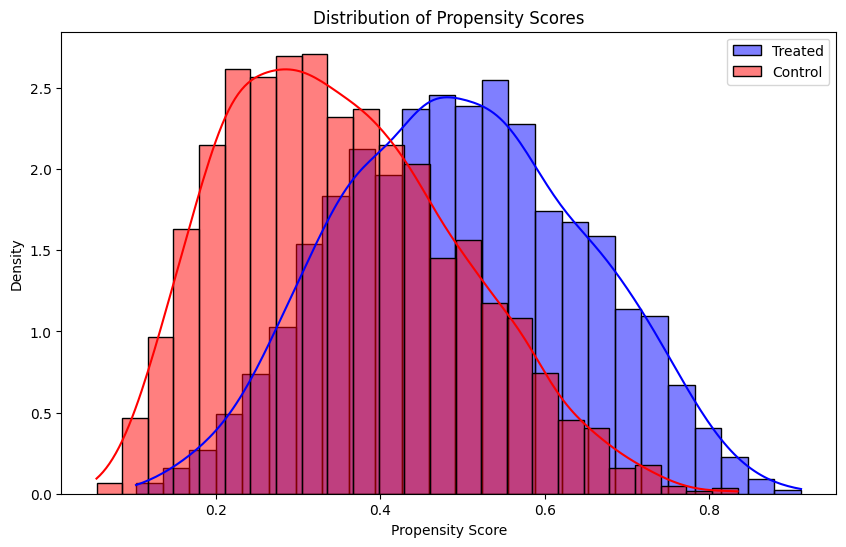

              Covariate  Mean_Treated  Mean_Control  SMD_Before  SMD_After  \
0   unhealthy_condition      0.934201      0.925478    0.034156   0.690963   
1                ALQ121      0.093999      0.149547   -0.170476   0.080333   
2              INDFMIN2      8.582068      8.726083   -0.032245   0.478738   
3              RIAGENDR      1.036876      0.933535    0.103491   0.304079   
4        RIDAGEYR_fixed     49.586406     49.438570    0.008176   0.570984   
5                SLD012      7.456255      7.629909   -0.105691   0.688142   
6               BPXPULS      0.041215      0.029204    0.065199   0.069631   
7             Sys_AVEBP    127.434081    123.141994    0.234341   0.829743   
8              exercise      0.438901      0.546828   -0.217144   0.237317   
9              WH_ratio      0.970177      0.915960    0.702117   0.963850   
10           smoker_con      0.237166      0.276939   -0.091106   0.149448   

    p-value_Before  p-value_After  
0     3.321282e-01   2.2499

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Add the propensity scores to the original DataFrame
df1_no_na['propensity_score'] = propensity_scores
df1_no_na['weights'] = np.where(df1_no_na['BMI_above_30'] == 1, weights_treatment, weights_control)

# Plot the distribution of propensity scores
plt.figure(figsize=(10, 6))
sns.histplot(df1_no_na[df1_no_na['BMI_above_30'] == 1]['propensity_score'], label='Treated', color='blue', kde=True, stat="density", bins=25)
sns.histplot(df1_no_na[df1_no_na['BMI_above_30'] == 0]['propensity_score'], label='Control', color='red', kde=True, stat="density", bins=25)
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores')
plt.legend()
plt.show()

# Function to calculate standardized mean difference
def standardized_mean_difference(group1, group2):
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1)**2 + np.std(group2)**2) / 2)
    return mean_diff / pooled_std

# Check covariate balance before and after weighting
covariate_columns = covariates.columns
balance_data = []

for covariate in covariate_columns:
    treated_group = df1_no_na[df1_no_na['BMI_above_30'] == 1][covariate]
    control_group = df1_no_na[df1_no_na['BMI_above_30'] == 0][covariate]

    # Calculate means before weighting
    mean_treated_before = np.mean(treated_group)
    mean_control_before = np.mean(control_group)

    # Calculate SMD before weighting
    smd_before = standardized_mean_difference(treated_group, control_group)

    # Calculate t-test before weighting
    t_stat_before, p_val_before = ttest_ind(treated_group, control_group)

    # Calculate means after weighting
    mean_treated_after = np.average(df1_no_na[df1_no_na['BMI_above_30'] == 1][covariate], weights=df1_no_na[df1_no_na['BMI_above_30'] == 1]['weights'])
    mean_control_after = np.average(df1_no_na[df1_no_na['BMI_above_30'] == 0][covariate], weights=df1_no_na[df1_no_na['BMI_above_30'] == 0]['weights'])

    # Calculate SMD after weighting
    smd_after = standardized_mean_difference(
        df1_no_na[df1_no_na['BMI_above_30'] == 1][covariate] * df1_no_na[df1_no_na['BMI_above_30'] == 1]['weights'],
        df1_no_na[df1_no_na['BMI_above_30'] == 0][covariate] * df1_no_na[df1_no_na['BMI_above_30'] == 0]['weights']
    )

    # Calculate t-test after weighting
    t_stat_after, p_val_after = ttest_ind(
        df1_no_na[df1_no_na['BMI_above_30'] == 1][covariate] * df1_no_na[df1_no_na['BMI_above_30'] == 1]['weights'],
        df1_no_na[df1_no_na['BMI_above_30'] == 0][covariate] * df1_no_na[df1_no_na['BMI_above_30'] == 0]['weights']
    )

    # Append to balance data
    balance_data.append({
        'Covariate': covariate,
        'Mean_Treated': mean_treated_before,
        'Mean_Control': mean_control_before,
        'SMD_Before': smd_before,
        'SMD_After': smd_after,
        'p-value_Before': p_val_before,
        'p-value_After': p_val_after
    })

balance_table = pd.DataFrame(balance_data)

print(balance_table)

print(df1_no_na.sort_values(by='propensity_score', ascending=True))


In [ ]:
##IPWE

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# Define treatment and covariates
X = df1_no_na[['BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con']]
y = df1_no_na['LBDHDD']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['BMI_above_30']
covariates = X.drop(columns=['BMI_above_30'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Calculate Weights
weights_treatment = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

# Filter the weights to match the corresponding treatment and control groups
weights_treatment_filtered = weights_treatment[treatment == 1]
weights_control_filtered = weights_control[treatment == 0]

# Step 3: Estimate ATE using the average of weighted outcomes method
# Weighted outcomes for treatment and control groups
weighted_outcome_treatment = np.sum(weights_treatment_filtered * y[treatment == 1]) / np.sum(weights_treatment_filtered)
weighted_outcome_control = np.sum(weights_control_filtered * y[treatment == 0]) / np.sum(weights_control_filtered)

# Calculate ATE
ate_ipw = weighted_outcome_treatment - weighted_outcome_control

# Calculate standard errors for IPW
# Compute the weighted residuals
residuals_treatment = weights_treatment_filtered * (y[treatment == 1] - weighted_outcome_treatment)
residuals_control = weights_control_filtered * (y[treatment == 0] - weighted_outcome_control)

# Variance of ATE
variance_ate_ipw = (np.sum(residuals_treatment ** 2) / (np.sum(weights_treatment_filtered) ** 2)) + (np.sum(residuals_control ** 2) / (np.sum(weights_control_filtered) ** 2))

# Standard error of ATE
ate_ipw_se = np.sqrt(variance_ate_ipw)

# Step 4: Doubly Robust Estimation
# Fit outcome regression models
outcome_model_treated = LinearRegression().fit(covariates[treatment == 1], y[treatment == 1])
outcome_model_control = LinearRegression().fit(covariates[treatment == 0], y[treatment == 0])

# Predict outcomes
y_hat_treated = outcome_model_treated.predict(covariates)
y_hat_control = outcome_model_control.predict(covariates)

# Calculate the doubly robust estimates
dr_estimate_treated = y_hat_treated + (treatment / propensity_scores) * (y - y_hat_treated)
dr_estimate_control = y_hat_control + ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Calculate ATE using doubly robust estimates
ate_dr = np.mean(dr_estimate_treated - dr_estimate_control)

# Calculate standard errors for DR
# Residuals for DR
residuals_dr_treated = (treatment / propensity_scores) * (y - y_hat_treated)
residuals_dr_control = ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Variance of ATE for DR
variance_ate_dr = np.var(dr_estimate_treated - dr_estimate_control) / len(y)

# Standard error of ATE for DR
ate_dr_se = np.sqrt(variance_ate_dr)

print(f"The estimated Average Treatment Effect (ATE) using IPW is: {ate_ipw}")
print(f"The standard error of the ATE estimate using IPW is: {ate_ipw_se}")
print(f"The estimated Average Treatment Effect (ATE) using Doubly Robust method is: {ate_dr}")
print(f"The standard error of the ATE estimate using Doubly Robust method is: {ate_dr_se}")


The estimated Average Treatment Effect (ATE) using IPW is: -5.873591943212382
The standard error of the ATE estimate using IPW is: 0.555550296140585
The estimated Average Treatment Effect (ATE) using Doubly Robust method is: -4.766905641134155
The standard error of the ATE estimate using Doubly Robust method is: 0.4618685358128632


####Method 4.AIPWE

In [ ]:
##AIPWE

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Assuming df1_no_na is your DataFrame

# Define treatment and covariates
X = df1_no_na[['BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con']]
y = df1_no_na['LBDHDD']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['BMI_above_30']
covariates = X.drop(columns=['BMI_above_30'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Calculate Weights
weights_treatment = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

# Step 3: Outcome Regression Models
# Train-test split
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(covariates, treatment, y, test_size=0.2, random_state=66)

# Outcome regression model for treated and control groups
outcome_model_treated = GradientBoostingRegressor(n_estimators=100, random_state=66)
outcome_model_control = GradientBoostingRegressor(n_estimators=100, random_state=66)

# Fit models on treated and control groups
outcome_model_treated.fit(X_train[T_train == 1], y_train[T_train == 1])
outcome_model_control.fit(X_train[T_train == 0], y_train[T_train == 0])

# Predict potential outcomes
y_pred_treated = outcome_model_treated.predict(covariates)
y_pred_control = outcome_model_control.predict(covariates)

# Step 4: Calculate AIPWE
aipwe = (treatment * (y - y_pred_treated) / propensity_scores) - ((1 - treatment) * (y - y_pred_control) / (1 - propensity_scores)) + (y_pred_treated - y_pred_control)
ate_aipwe = np.mean(aipwe)

# Calculate standard errors for AIPWE
n = len(aipwe)
se_aipwe = np.sqrt(np.var(aipwe) / n)

# Calculate t-statistic
t_statistic = ate_aipwe / se_aipwe

print(f"AIPWE Estimate of ATE: {ate_aipwe}")
print(f"Standard Error of AIPWE Estimate: {se_aipwe}")
print(f"T-statistic: {t_statistic}")

AIPWE Estimate of ATE: -4.615438142306754
Standard Error of AIPWE Estimate: 0.42824889638690017
T-statistic: -10.777466518295357


####Method 5.Doubly Robust PLM

In [ ]:
##PLM

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Assuming df1_no_na is your DataFrame

# Define treatment and covariates
X = df1_no_na[[ 'BMI_above_30', 'unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'SLD012','BPXPULS','Sys_AVEBP', 'exercise', 'WH_ratio','smoker_con']]
y = df1_no_na['LBDHDD']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['BMI_above_30']
covariates = X.drop(columns=['BMI_above_30'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Outcome Regression using Partially Linear Model (PLM)
# Fit outcome regression models using a flexible model like RandomForestRegressor
outcome_model_treated = RandomForestRegressor(n_estimators=100, random_state=0).fit(covariates[treatment == 1], y[treatment == 1])
outcome_model_control = RandomForestRegressor(n_estimators=100, random_state=0).fit(covariates[treatment == 0], y[treatment == 0])

# Predict outcomes
y_hat_treated = outcome_model_treated.predict(covariates)
y_hat_control = outcome_model_control.predict(covariates)

# Calculate the doubly robust estimates
dr_estimate_treated = y_hat_treated + (treatment / propensity_scores) * (y - y_hat_treated)
dr_estimate_control = y_hat_control + ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Calculate ATE using doubly robust PLM estimates
ate_dr_plm = np.mean(dr_estimate_treated - dr_estimate_control)

# Calculate standard errors for DR PLM
# Residuals for DR PLM
residuals_dr_treated = (treatment / propensity_scores) * (y - y_hat_treated)
residuals_dr_control = ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Variance of ATE for DR PLM
variance_ate_dr_plm = np.var(dr_estimate_treated - dr_estimate_control) / len(y)

# Standard error of ATE for DR PLM
ate_dr_plm_se = np.sqrt(variance_ate_dr_plm)

# Calculate t-statistic
t_statistic = ate_dr_plm / ate_dr_plm_se

print(f"The estimated Average Treatment Effect (ATE) using Doubly Robust PLM method is: {ate_dr_plm}")
print(f"The standard error of the ATE estimate using Doubly Robust PLM method is: {ate_dr_plm_se}")
print(f"The t-statistic is: {t_statistic}")

The estimated Average Treatment Effect (ATE) using Doubly Robust PLM method is: -4.593955411721423
The standard error of the ATE estimate using Doubly Robust PLM method is: 0.32254193303488715
The t-statistic is: -14.24297104099183


### Hypothesis 2.LBDHDD ~ smoker_con

EDA

In [ ]:
#EDA
import pandas as pd
import matplotlib.pyplot as plt

df1_no_na = df1[['LBDHDD', 'smoker_con','ALQ121', 'BMXBMI','unhealthy_condition', 'SLD012', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'BPXPULS', 'exercise']].dropna()

print(f"Observed units: {len(df1_no_na)}")

# Creating the histogram for LBDHDD
plt.figure(figsize=(10, 6))
plt.hist(df1_no_na['LBDHDD'], bins=20, edgecolor='black')
plt.title('Distribution of LBDHDD')
plt.xlabel('LBDHDD')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Creating the pie chart for smoker_con
smoker_counts = df1_no_na['smoker_con'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(smoker_counts, labels=["Not Smoker", 'Smoker'], autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Smokers')
plt.show()

####Method 1.Regression-based w/o interactions

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import statsmodels.api as sm

X = df1_no_na[['smoker_con','ALQ121', 'BMXBMI','unhealthy_condition', 'SLD012', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'BPXPULS', 'exercise']]
y = df1_no_na['LBDHDD']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

#OLS
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model_ate = sm.OLS(y_train, X_train).fit(cov_type='HC1')  # Fit OLS model
# Predict probabilities on the test set
y_pred = model_ate.predict(X_test)
# Calculate MSE
test_mse_ols = mean_squared_error(y_test, y_pred)
print(f'OLS Test MSE: {test_mse_ols}')


# Function to print the results of the grid search
def print_best_params_and_mse(model_name, grid_search, X_test, y_test):
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    y_pred = grid_search.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{model_name} Test MSE: {mse}")
    return mse

# Standardize the variables for lasso
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lasso Regression Parameter Tuning
lasso = Lasso()
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5)
lasso_grid.fit(X_train_scaled, y_train)
test_mse_lasso = print_best_params_and_mse('Lasso', lasso_grid, X_test_scaled, y_test)

# Random Forest Parameter Tuning
rf = RandomForestRegressor(random_state=66)
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5)
rf_grid.fit(X_train, y_train)
test_mse_rf = print_best_params_and_mse('Random Forest', rf_grid, X_test, y_test)

# Gradient Boosting Parameter Tuning
gbr = GradientBoostingRegressor(random_state=66)
gbr_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gbr_grid = GridSearchCV(gbr, gbr_params, cv=5)
gbr_grid.fit(X_train, y_train)
test_mse_gbr = print_best_params_and_mse('Gradient Boosting', gbr_grid, X_test, y_test)

print(f"Lasso Best MSE: {test_mse_lasso}")
print(f"Random Forest Best MSE: {test_mse_rf}")
print(f"Gradient Boosting Best MSE: {test_mse_gbr}")

In [ ]:
#Estimate ATE and its standard error using Gradient Boosting and bootstrap

from sklearn.utils import resample

# Define the function to calculate ATE
def calculate_ate(X, y, random_state=66):
    gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50, random_state=random_state)
    gbr.fit(X, y)

    X_smoker = X.copy()
    X_smoker['smoker_con'] = 1
    X_not_smoker = X.copy()
    X_not_smoker['smoker_con'] = 0

    y_pred_smoker = gbr.predict(X_smoker)
    y_pred_not_smoker = gbr.predict(X_not_smoker)

    ate = y_pred_smoker.mean() - y_pred_not_smoker.mean()

    return ate

ate = calculate_ate(X, y, random_state=66)

# Bootstrap to estimate the standard error of ATE
n_iterations = 100
ate_bootstrap = []

for i in range(n_iterations):
    X_resampled, y_resampled = resample(X, y, random_state=i)
    ate_bootstrap.append(calculate_ate(X_resampled, y_resampled))

ate_bootstrap = np.array(ate_bootstrap)
ate_std_error = np.std(ate_bootstrap)

print(f"ATE estimate by Gradient Boosting: {ate:.4f}")
print(f"Standard error of ATE estimate: {ate_std_error:.4f}")
print(f"t-statistic of ATE estimate: {ate/ate_std_error:.4f}")


####Method 2.Regression-based with interactions

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from itertools import combinations

X = df1_no_na[['smoker_con','ALQ121', 'BMXBMI','unhealthy_condition', 'SLD012', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'BPXPULS', 'exercise']]
y = df1_no_na['LBDHDD']

# Create pairwise interaction terms for X
interaction_terms = pd.DataFrame(index=X.index)
# Get the list of feature names
feature_names = X.columns
# Generate interaction terms
for (i, j) in combinations(feature_names, 2):
    interaction_terms[f'{i}:{j}'] = X[i] * X[j]

# Combine the original features with the interaction terms
X_inter = pd.concat([X, interaction_terms], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_inter, y, test_size=0.2, random_state=66)

#OLS
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model_ate = sm.OLS(y_train, X_train).fit(cov_type='HC1')  # Fit OLS model
# Predict probabilities on the test set
y_pred = model_ate.predict(X_test)
# Calculate MSE
test_mse_ols = mean_squared_error(y_test, y_pred)
print(f'OLS Test MSE: {test_mse_ols}')


# Function to print the results of the grid search
def print_best_params_and_mse(model_name, grid_search, X_test, y_test):
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    y_pred = grid_search.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{model_name} Test MSE: {mse}")
    return mse

# Standardize the variables for lasso
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lasso Regression Parameter Tuning
lasso = Lasso()
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5)
lasso_grid.fit(X_train_scaled, y_train)
test_mse_lasso = print_best_params_and_mse('Lasso', lasso_grid, X_test_scaled, y_test)

# Random Forest Parameter Tuning
rf = RandomForestRegressor(random_state=66)
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5)
rf_grid.fit(X_train, y_train)
test_mse_rf = print_best_params_and_mse('Random Forest', rf_grid, X_test, y_test)

# Gradient Boosting Parameter Tuning
gbr = GradientBoostingRegressor(random_state=66)
gbr_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gbr_grid = GridSearchCV(gbr, gbr_params, cv=5)
gbr_grid.fit(X_train, y_train)
test_mse_gbr = print_best_params_and_mse('Gradient Boosting', gbr_grid, X_test, y_test)

In [ ]:
#Estimate ATE and its standard error using Gradient Boosting and bootstrap(with interactions)

from sklearn.utils import resample

# Define the function to calculate ATE
def calculate_ate(X, y, random_state=66):

    def add_interaction_terms(X):
        # Create pairwise interaction terms for X
        interaction_terms = pd.DataFrame(index=X.index)
        # Get the list of feature names excluding the constant term
        feature_names = X.columns
        # Generate interaction terms
        for (i, j) in combinations(feature_names, 2):
            interaction_terms[f'{i}:{j}'] = X[i] * X[j]

        # Combine the original features with the interaction terms
        X_inter = pd.concat([X, interaction_terms], axis=1)
        return X_inter

    X_inter = add_interaction_terms(X)

    gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50, random_state=random_state)
    gbr.fit(X_inter, y)

    X_smoker = X.copy()
    X_smoker['smoker_con'] = 1
    X_smoker_inter = add_interaction_terms(X_smoker)

    X_not_smoker = X.copy()
    X_not_smoker['smoker_con'] = 0
    X_not_smoker_inter = add_interaction_terms(X_not_smoker)


    y_pred_smoker = gbr.predict(X_smoker_inter)
    y_pred_not_smoker = gbr.predict(X_not_smoker_inter)

    ate = y_pred_smoker.mean() - y_pred_not_smoker.mean()

    return ate

ate = calculate_ate(X, y, random_state=66)

# Bootstrap to estimate the standard error of ATE
n_iterations = 100
ate_bootstrap = []

for i in range(n_iterations):
    X_resampled, y_resampled = resample(X, y, random_state=i)
    ate_bootstrap.append(calculate_ate(X_resampled, y_resampled))

ate_bootstrap = np.array(ate_bootstrap)
ate_std_error = np.std(ate_bootstrap)

print(f"ATE estimate by Gradient Boosting(w/ interactions): {ate:.4f}")
print(f"Standard error of ATE estimate: {ate_std_error:.4f}")
print(f"t-statistic of ATE estimate: {ate/ate_std_error:.4f}")


####Method 3.Propensity score method

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Define treatment and covariates
X = df1_no_na[['smoker_con','ALQ121', 'BMXBMI','unhealthy_condition', 'SLD012', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'BPXPULS', 'exercise']]
y = df1_no_na['LBDHDD']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['smoker_con']
covariates = X.drop(columns=['smoker_con'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(covariates, treatment, test_size=0.2, random_state=66)

#OLS
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict_proba(X_test)[:, 1]
# Calculate AUC for Logistic Regression (Lasso)
auc_log_reg = roc_auc_score(y_test, y_pred)
print(f"AUC for Logistic Regression (OLS): {auc_log_reg:.4f}")


# Function to print the results of the grid search
def print_best_params_and_auc(model_name, grid_search, X_test, y_test):
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    y_pred = grid_search.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    print(f"{model_name} Test AUC: {auc}")
    return auc

# Standardize the variables for lasso
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lasso Regression Parameter Tuning
lasso = LogisticRegression(penalty='l1', solver='liblinear')
lasso_params = {'C': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5)
lasso_grid.fit(X_train_scaled, y_train)
test_auc_lasso = print_best_params_and_auc('Lasso', lasso_grid, X_test_scaled, y_test)

# Random Forest Parameter Tuning
rf = RandomForestClassifier(random_state=66)
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5)
rf_grid.fit(X_train, y_train)
test_auc_rf = print_best_params_and_auc('Random Forest', rf_grid, X_test, y_test)

# Gradient Boosting Parameter Tuning
gbr = GradientBoostingClassifier(random_state=66)
gbr_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gbr_grid = GridSearchCV(gbr, gbr_params, cv=5)
gbr_grid.fit(X_train, y_train)
test_auc_gbr = print_best_params_and_auc('Gradient Boosting', gbr_grid, X_test, y_test)



In [ ]:
# check overlap assumption
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

X = df1_no_na[['smoker_con','ALQ121', 'BMXBMI','unhealthy_condition', 'SLD012', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'BPXPULS', 'exercise']]
y = df1_no_na['LBDHDD']
treatment = X['smoker_con']
covariates = X.drop(columns=['smoker_con'])

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Add the propensity scores to the original DataFrame
X['propensity_score'] = propensity_scores
weights_treatment = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)
X['weights'] = np.where(X['smoker_con'] == 1, weights_treatment, weights_control)

# Plot the distribution of propensity scores
plt.figure(figsize=(10, 6))
sns.histplot(X[X['smoker_con'] == 1]['propensity_score'], label='Treated', color='blue', kde=False, stat="density", bins=25)
sns.histplot(X[X['smoker_con'] == 0]['propensity_score'], label='Control', color='red', kde=False, stat="density", bins=25)
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores')
plt.legend()
plt.show()

# Plot the distribution of propensity scores
plt.figure(figsize=(10, 6))
sns.histplot(X['propensity_score'], label='All', color='green', kde=False, stat="density", bins=25)
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores')
plt.legend()
plt.show()


In [ ]:
## trim propensity score < 0.05

y = y[X['propensity_score'] >= 0.05]
X = X[X['propensity_score'] >= 0.05]


# Plot the distribution of propensity scores
plt.figure(figsize=(10, 6))
sns.histplot(X[X['smoker_con'] == 1]['propensity_score'], label='Treated', color='blue', kde=False, stat="density", bins=25)
sns.histplot(X[X['smoker_con'] == 0]['propensity_score'], label='Control', color='red', kde=False, stat="density", bins=25)
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores')
plt.legend()
plt.show()

# Plot the distribution of propensity scores
plt.figure(figsize=(10, 6))
sns.histplot(X['propensity_score'], label='All', color='green', kde=False, stat="density", bins=25)
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores')
plt.legend()
plt.show()

print(X.sort_values(by='propensity_score', ascending=True))

In [ ]:
# estimate ATE using IPWE
# Estimate ATE using the average of weighted outcomes method
# Filter the weights to match the corresponding treatment and control groups
weights_treatment_filtered = X[X['smoker_con'] == 1]['weights']
weights_control_filtered = X[X['smoker_con'] == 0]['weights']

# Weighted outcomes for treatment and control groups
weighted_outcome_treatment = np.sum(weights_treatment_filtered * y[treatment == 1]) / np.sum(weights_treatment_filtered)
weighted_outcome_control = np.sum(weights_control_filtered * y[treatment == 0]) / np.sum(weights_control_filtered)

# Calculate ATE
ate = weighted_outcome_treatment - weighted_outcome_control

# Calculate standard errors
# Compute the weighted residuals
residuals_treatment = weights_treatment_filtered * (y[treatment == 1] - weighted_outcome_treatment)
residuals_control = weights_control_filtered * (y[treatment == 0] - weighted_outcome_control)

# Variance of ATE
variance_ate = (np.sum(residuals_treatment ** 2) / (np.sum(weights_treatment_filtered) ** 2)) + (np.sum(residuals_control ** 2) / (np.sum(weights_control_filtered) ** 2))

# Standard error of ATE
ate_se = np.sqrt(variance_ate)

print(f"The estimated Average Treatment Effect (ATE) is: {ate:.4f}")
print(f"The standard error of the ATE estimate is: {ate_se:.4f}")
print(f"t-statistic of ATE estimate: {ate/ate_se:.4f}")

####Method 4.AIPWE

In [ ]:
# Separate the covariates and outcomes
covariates_with_treatment = X.drop(columns=['propensity_score', 'weights'])
outcomes = y

# Step 1: Split the data into treatment and control groups
treatment = X['smoker_con']
propensity_scores = X['propensity_score']

# Step 2: Fit the outcome model including the treatment variable
gbr = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=3,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=50,
    random_state=66
)
gbr.fit(covariates_with_treatment, outcomes)

# Step 3: Predict potential outcomes for all units with treatment and control
covariates_treated = covariates_with_treatment.copy()
covariates_control = covariates_with_treatment.copy()
covariates_treated['smoker_con'] = 1
covariates_control['smoker_con'] = 0

pred_treatment_all = gbr.predict(covariates_treated)
pred_control_all = gbr.predict(covariates_control)

# Step 4: Calculate AIPWE
# Calculate the AIPWE components
term1 = (treatment * (outcomes - pred_treatment_all) / propensity_scores)
term2 = ((1 - treatment) * (outcomes - pred_control_all) / (1 - propensity_scores))
term3 = pred_treatment_all - pred_control_all

# Calculate the ATE
AIPWE = np.mean(term1 - term2 + term3)

# Step 5: Bootstrap to estimate standard error of ATE
n_bootstraps = 100
ate_bootstrap = np.zeros(n_bootstraps)

for i in range(n_bootstraps):
    # Resample the data with replacement
    X_resampled, y_resampled = resample(X, y, replace=True, n_samples=len(X), random_state=i)

    # Separate the covariates and outcomes for the resampled data
    covariates_with_treatment_resampled = X_resampled.drop(columns=['propensity_score', 'weights'])
    outcomes_resampled = y_resampled

    # Fit the outcome model on the resampled data
    gbr_resampled = GradientBoostingRegressor(
        learning_rate=0.1,
        max_depth=3,
        min_samples_leaf=4,
        min_samples_split=10,
        n_estimators=50,
        random_state=66
    )
    gbr_resampled.fit(covariates_with_treatment_resampled, outcomes_resampled)

    # Predict potential outcomes for all units with treatment and control
    covariates_treated_resampled = covariates_with_treatment_resampled.copy()
    covariates_control_resampled = covariates_with_treatment_resampled.copy()
    covariates_treated_resampled['smoker_con'] = 1
    covariates_control_resampled['smoker_con'] = 0

    pred_treatment_all_resampled = gbr_resampled.predict(covariates_treated_resampled)
    pred_control_all_resampled = gbr_resampled.predict(covariates_control_resampled)

    # Calculate the AIPWE for the resampled data
    propensity_scores_resampled = X_resampled['propensity_score']
    treatment_resampled = X_resampled['smoker_con']

    term1_resampled = (treatment_resampled * (outcomes_resampled - pred_treatment_all_resampled) / propensity_scores_resampled)
    term2_resampled = ((1 - treatment_resampled) * (outcomes_resampled - pred_control_all_resampled) / (1 - propensity_scores_resampled))
    term3_resampled = pred_treatment_all_resampled - pred_control_all_resampled

    ate_bootstrap[i] = np.mean(term1_resampled - term2_resampled + term3_resampled)

# Calculate the standard error of the ATE
ate_standard_error = np.std(ate_bootstrap)

print(f"The estimated ATE using Doubly Robust method: {AIPWE:.4f}")
print(f"The standard error of the ATE estimate: {ate_standard_error:.4f}")
print(f"The t-statistic of the ATE estimate: {AIPWE/ate_standard_error:.4f}")


####Method 5.Doubly Robust PLM

In [ ]:
X = df1_no_na[['smoker_con','ALQ121', 'BMXBMI','unhealthy_condition', 'SLD012', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'BPXPULS', 'exercise']]
y = df1_no_na['LBDHDD']
treatment = X['smoker_con']
covariates = X.drop(columns=['smoker_con'])


# get the outcome regression residual
gbr = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=3,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=50,
    random_state=66
)
gbr.fit(covariates, y)
y_hat = gbr.predict(covariates)
y_residual = y - y_hat

# get the treatment regression residual
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]
t_residual = treatment - propensity_scores

# remove units with propensity score < 5%
y_residual = y_residual[propensity_scores >= 0.05]
t_residual = t_residual[propensity_scores >= 0.05]


# Residual-on-residual regression
t_residual = sm.add_constant(t_residual)
plm_model = sm.OLS(y_residual, t_residual).fit()
print(plm_model.summary())

### Hypothesis 3.LBDHDD ~ sleep_well

#### Method 1. Regression-based w/o interactions

In [ ]:
##
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error

df1_no_na = df1[['LBDHDD','sleep_well', 'BMXBMI','unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'BPXPULS', 'exercise']].dropna()
print(df1_no_na['LBDHDD'].value_counts())
print(df1_no_na['sleep_well'].value_counts())


X = df1_no_na[['sleep_well', 'BMXBMI','unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'BPXPULS', 'exercise']]
y = df1_no_na['LBDHDD']
x_categorical_name_list = []
X = pd.get_dummies(X, columns=x_categorical_name_list, drop_first=True)
transformed_columns = [col for col in X.columns if any(prefix in col for prefix in x_categorical_name_list)]
X[transformed_columns] = X[transformed_columns].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

def ATE_est_reg(X_train, X_test, y_train, y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model_ate = sm.OLS(y_train, X_train).fit(cov_type='HC1')  # Fit OLS model
    ate_summary = model_ate.summary()
    print(ate_summary)
    # Predict probabilities on the test set
    y_pred = model_ate.predict(X_test)

    # Calculate R-squared and MSE
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f'R-squared: {r2}, MSE: {mse}')
    return


ATE_est_reg(X_train, X_test, y_train, y_test)

LBDHDD
48.0     186
41.0     174
54.0     156
45.0     113
44.0     111
        ... 
11.0       1
21.0       1
98.0       1
115.0      1
126.0      1
Name: count, Length: 101, dtype: int64
sleep_well
1    2838
0    1001
Name: count, dtype: int64
                            OLS Regression Results                            
Dep. Variable:                 LBDHDD   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     105.6
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          1.69e-172
Time:                        02:14:17   Log-Likelihood:                -12341.
No. Observations:                3071   AIC:                         2.470e+04
Df Residuals:                    3061   BIC:                         2.476e+04
Df Model:                           9                                         
Covariance Type:                  HC1      

#### Method 2. Regression-based w/ interactions

In [ ]:
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import roc_auc_score
from itertools import combinations

def ATE_est_reg_interaction(X_train, X_test, y_train, y_test):
    # Add constant term to the features
    cols_to_subtract_mean = X_train.columns[X_train.columns != 'sleep_well']
    X_train[cols_to_subtract_mean] = X_train[cols_to_subtract_mean] - X_train[cols_to_subtract_mean].mean()
    X_test[cols_to_subtract_mean] = X_test[cols_to_subtract_mean] - X_test[cols_to_subtract_mean].mean()
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Create pairwise interaction terms for X_train
    interaction_terms_train = pd.DataFrame(index=X_train.index)
    interaction_terms_test = pd.DataFrame(index=X_test.index)

    # Get the list of feature names excluding the constant term
    feature_names = X_train.columns[1:]

    # Generate interaction terms
    for (i, j) in combinations(feature_names, 2):
        interaction_terms_train[f'{i}:{j}'] = X_train[i] * X_train[j]
        interaction_terms_test[f'{i}:{j}'] = X_test[i] * X_test[j]

    # Combine the original features with the interaction terms
    X_train_inter = pd.concat([X_train, interaction_terms_train], axis=1)
    X_test_inter = pd.concat([X_test, interaction_terms_test], axis=1)

    # Fit the logistic regression model
    model_ate = sm.OLS(y_train, X_train_inter).fit(cov_type='HC1')  # Fit OLS model
    ate_summary = model_ate.summary()
    print(ate_summary)

    # Predict probabilities on the test set
    y_pred = model_ate.predict(X_test_inter)

    # Calculate R-squared and MSE
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f'R-squared: {r2}, MSE: {mse}')
    return

ATE_est_reg_interaction(X_train, X_test, y_train, y_test)



                            OLS Regression Results                            
Dep. Variable:                 LBDHDD   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     25.93
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          6.83e-179
Time:                        02:14:23   Log-Likelihood:                -12299.
No. Observations:                3071   AIC:                         2.469e+04
Df Residuals:                    3025   BIC:                         2.497e+04
Df Model:                          45                                         
Covariance Type:                  HC1                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

#### Method 3. IPWE

In [ ]:
#propensity method

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# Assuming df1_no_na is your DataFrame

# Define treatment and covariates
X = df1_no_na[['sleep_well', 'BMXBMI','unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'BPXPULS', 'exercise']]
y = df1_no_na['LBDHDD']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['sleep_well']
covariates = X.drop(columns=['sleep_well'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Calculate Weights
weights_treatment = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

# Step 3: Estimate ATE using the average of weighted outcomes method
# Filter the weights to match the corresponding treatment and control groups
weights_treatment_filtered = weights_treatment[treatment == 1]
weights_control_filtered = weights_control[treatment == 0]

# Weighted outcomes for treatment and control groups
weighted_outcome_treatment = np.sum(weights_treatment_filtered * y[treatment == 1]) / np.sum(weights_treatment_filtered)
weighted_outcome_control = np.sum(weights_control_filtered * y[treatment == 0]) / np.sum(weights_control_filtered)

# Calculate ATE
ate = weighted_outcome_treatment - weighted_outcome_control

# Calculate standard errors
# Compute the weighted residuals
residuals_treatment = weights_treatment_filtered * (y[treatment == 1] - weighted_outcome_treatment)
residuals_control = weights_control_filtered * (y[treatment == 0] - weighted_outcome_control)

# Variance of ATE
variance_ate = (np.sum(residuals_treatment ** 2) / (np.sum(weights_treatment_filtered) ** 2)) + (np.sum(residuals_control ** 2) / (np.sum(weights_control_filtered) ** 2))

# Standard error of ATE
ate_se = np.sqrt(variance_ate)

print(f"The estimated Average Treatment Effect (ATE) is: {ate}")
print(f"The standard error of the ATE estimate is: {ate_se}")

The estimated Average Treatment Effect (ATE) is: -0.5613166604889699
The standard error of the ATE estimate is: 0.6066065700382592


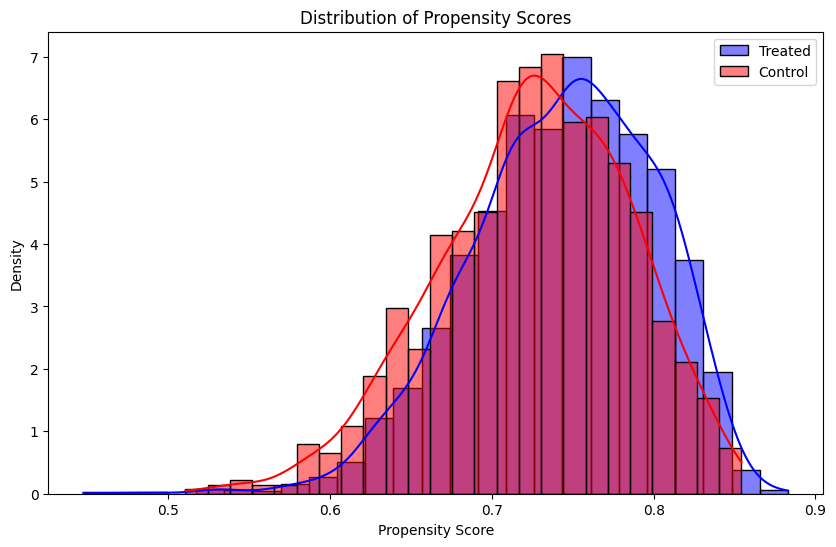

             Covariate  Mean_Treated  Mean_Control  SMD_Before  SMD_After  \
0               BMXBMI     29.563108     30.866134   -0.171075  -3.661326   
1  unhealthy_condition      0.927061      0.937063   -0.039754  -2.521619   
2               ALQ121      0.125793      0.127872   -0.006248  -0.320579   
3             INDFMIN2      8.532770      8.818182   -0.063668  -1.601791   
4             RIAGENDR      1.028189      0.859141    0.169927  -0.738216   
5       RIDAGEYR_fixed     50.207893     49.519481    0.038891  -1.993229   
6              BPXPULS      0.038055      0.032967    0.027495  -0.157565   
7             exercise      0.508809      0.445554    0.126896  -0.753133   

   p-value_Before  p-value_After  
0        0.000002   0.000000e+00  
1        0.287443   0.000000e+00  
2        0.864853   9.021035e-28  
3        0.083019   0.000000e+00  
4        0.000004  1.453032e-137  
5        0.304585   0.000000e+00  
6        0.461961   4.232389e-08  
7        0.000575  2.69174

In [ ]:
# Check Overlap Assumption and Covariate Balance
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Add the propensity scores to the original DataFrame
df1_no_na['propensity_score'] = propensity_scores
df1_no_na['weights'] = np.where(df1_no_na['sleep_well'] == 1, weights_treatment, weights_control)

# Plot the distribution of propensity scores
plt.figure(figsize=(10, 6))
sns.histplot(df1_no_na[df1_no_na['sleep_well'] == 1]['propensity_score'], label='Treated', color='blue', kde=True, stat="density", bins=25)
sns.histplot(df1_no_na[df1_no_na['sleep_well'] == 0]['propensity_score'], label='Control', color='red', kde=True, stat="density", bins=25)
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores')
plt.legend()
plt.show()

# Function to calculate standardized mean difference
def standardized_mean_difference(group1, group2):
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1)**2 + np.std(group2)**2) / 2)
    return mean_diff / pooled_std

# Check covariate balance before and after weighting
covariate_columns = covariates.columns
balance_data = []

for covariate in covariate_columns:
    treated_group = df1_no_na[df1_no_na['sleep_well'] == 1][covariate]
    control_group = df1_no_na[df1_no_na['sleep_well'] == 0][covariate]

    # Calculate means before weighting
    mean_treated_before = np.mean(treated_group)
    mean_control_before = np.mean(control_group)

    # Calculate SMD before weighting
    smd_before = standardized_mean_difference(treated_group, control_group)

    # Calculate t-test before weighting
    t_stat_before, p_val_before = ttest_ind(treated_group, control_group)

    # Calculate means after weighting
    mean_treated_after = np.average(df1_no_na[df1_no_na['sleep_well'] == 1][covariate], weights=df1_no_na[df1_no_na['sleep_well'] == 1]['weights'])
    mean_control_after = np.average(df1_no_na[df1_no_na['sleep_well'] == 0][covariate], weights=df1_no_na[df1_no_na['sleep_well'] == 0]['weights'])

    # Calculate SMD after weighting
    smd_after = standardized_mean_difference(
        df1_no_na[df1_no_na['sleep_well'] == 1][covariate] * df1_no_na[df1_no_na['sleep_well'] == 1]['weights'],
        df1_no_na[df1_no_na['sleep_well'] == 0][covariate] * df1_no_na[df1_no_na['sleep_well'] == 0]['weights']
    )

    # Calculate t-test after weighting
    t_stat_after, p_val_after = ttest_ind(
        df1_no_na[df1_no_na['sleep_well'] == 1][covariate] * df1_no_na[df1_no_na['sleep_well'] == 1]['weights'],
        df1_no_na[df1_no_na['sleep_well'] == 0][covariate] * df1_no_na[df1_no_na['sleep_well'] == 0]['weights']
    )

    # Append to balance data
    balance_data.append({
        'Covariate': covariate,
        'Mean_Treated': mean_treated_before,
        'Mean_Control': mean_control_before,
        'SMD_Before': smd_before,
        'SMD_After': smd_after,
        'p-value_Before': p_val_before,
        'p-value_After': p_val_after
    })

balance_table = pd.DataFrame(balance_data)

print(balance_table)

print(df1_no_na.sort_values(by='propensity_score', ascending=True))

#### Method 4. AIPW

In [ ]:
# doubly
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# Assuming df1_no_na is your DataFrame

# Define treatment and covariates
X = df1_no_na[['sleep_well', 'BMXBMI','unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'BPXPULS', 'exercise']]
y = df1_no_na['LBDHDD']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['sleep_well']
covariates = X.drop(columns=['sleep_well'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Calculate Weights
weights_treatment = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

# Filter the weights to match the corresponding treatment and control groups
weights_treatment_filtered = weights_treatment[treatment == 1]
weights_control_filtered = weights_control[treatment == 0]

# Step 3: Estimate ATE using the average of weighted outcomes method
# Weighted outcomes for treatment and control groups
weighted_outcome_treatment = np.sum(weights_treatment_filtered * y[treatment == 1]) / np.sum(weights_treatment_filtered)
weighted_outcome_control = np.sum(weights_control_filtered * y[treatment == 0]) / np.sum(weights_control_filtered)

# Calculate ATE
ate_ipw = weighted_outcome_treatment - weighted_outcome_control

# Calculate standard errors for IPW
# Compute the weighted residuals
residuals_treatment = weights_treatment_filtered * (y[treatment == 1] - weighted_outcome_treatment)
residuals_control = weights_control_filtered * (y[treatment == 0] - weighted_outcome_control)

# Variance of ATE
variance_ate_ipw = (np.sum(residuals_treatment ** 2) / (np.sum(weights_treatment_filtered) ** 2)) + (np.sum(residuals_control ** 2) / (np.sum(weights_control_filtered) ** 2))

# Standard error of ATE
ate_ipw_se = np.sqrt(variance_ate_ipw)

# Step 4: Doubly Robust Estimation
# Fit outcome regression models
outcome_model_treated = LinearRegression().fit(covariates[treatment == 1], y[treatment == 1])
outcome_model_control = LinearRegression().fit(covariates[treatment == 0], y[treatment == 0])

# Predict outcomes
y_hat_treated = outcome_model_treated.predict(covariates)
y_hat_control = outcome_model_control.predict(covariates)

# Calculate the doubly robust estimates
dr_estimate_treated = y_hat_treated + (treatment / propensity_scores) * (y - y_hat_treated)
dr_estimate_control = y_hat_control + ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Calculate ATE using doubly robust estimates
ate_dr = np.mean(dr_estimate_treated - dr_estimate_control)

# Calculate standard errors for DR
# Residuals for DR
residuals_dr_treated = (treatment / propensity_scores) * (y - y_hat_treated)
residuals_dr_control = ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Variance of ATE for DR
variance_ate_dr = np.var(dr_estimate_treated - dr_estimate_control) / len(y)

# Standard error of ATE for DR
ate_dr_se = np.sqrt(variance_ate_dr)

print(f"The estimated Average Treatment Effect (ATE) using IPW is: {ate_ipw}")
print(f"The standard error of the ATE estimate using IPW is: {ate_ipw_se}")
print(f"The estimated Average Treatment Effect (ATE) using Doubly Robust method is: {ate_dr}")
print(f"The standard error of the ATE estimate using Doubly Robust method is: {ate_dr_se}")


The estimated Average Treatment Effect (ATE) using IPW is: -0.5613166604889699
The standard error of the ATE estimate using IPW is: 0.6066065700382592
The estimated Average Treatment Effect (ATE) using Doubly Robust method is: -0.5759417793855983
The standard error of the ATE estimate using Doubly Robust method is: 0.5385420243291216


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# Assuming df1_no_na is your DataFrame

# Define treatment and covariates
#X = df1_no_na[['sleep_well', 'BMXBMI','unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'BPXPULS', 'exercise']]
#y = df1_no_na['LBDHDD']
X = df1_no_na[['sleep_well', 'BMXBMI','unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'BPXPULS', 'exercise']]
y = df1_no_na['LBDHDD']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['sleep_well']
covariates = X.drop(columns=['sleep_well'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Calculate Weights
weights_treatment = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

# Filter the weights to match the corresponding treatment and control groups
weights_treatment_filtered = weights_treatment[treatment == 1]
weights_control_filtered = weights_control[treatment == 0]

# Step 3: Estimate ATE using the average of weighted outcomes method
# Weighted outcomes for treatment and control groups
weighted_outcome_treatment = np.sum(weights_treatment_filtered * y[treatment == 1]) / np.sum(weights_treatment_filtered)
weighted_outcome_control = np.sum(weights_control_filtered * y[treatment == 0]) / np.sum(weights_control_filtered)

# Calculate ATE
ate_ipw = weighted_outcome_treatment - weighted_outcome_control

# Calculate standard errors for IPW
# Compute the weighted residuals
residuals_treatment = weights_treatment_filtered * (y[treatment == 1] - weighted_outcome_treatment)
residuals_control = weights_control_filtered * (y[treatment == 0] - weighted_outcome_control)

# Variance of ATE
variance_ate_ipw = (np.sum(residuals_treatment ** 2) / (np.sum(weights_treatment_filtered) ** 2)) + (np.sum(residuals_control ** 2) / (np.sum(weights_control_filtered) ** 2))

# Standard error of ATE
ate_ipw_se = np.sqrt(variance_ate_ipw)

# Step 4: Doubly Robust Estimation
# Fit outcome regression models
outcome_model_treated = LinearRegression().fit(covariates[treatment == 1], y[treatment == 1])
outcome_model_control = LinearRegression().fit(covariates[treatment == 0], y[treatment == 0])

# Predict outcomes
y_hat_treated = outcome_model_treated.predict(covariates)
y_hat_control = outcome_model_control.predict(covariates)

# Calculate the doubly robust estimates
dr_estimate_treated = y_hat_treated + (treatment / propensity_scores) * (y - y_hat_treated)
dr_estimate_control = y_hat_control + ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Calculate ATE using doubly robust estimates
ate_dr = np.mean(dr_estimate_treated - dr_estimate_control)

# Calculate standard errors for DR
# Residuals for DR
residuals_dr_treated = (treatment / propensity_scores) * (y - y_hat_treated)
residuals_dr_control = ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Variance of ATE for DR
variance_ate_dr = np.var(dr_estimate_treated - dr_estimate_control) / len(y)

# Standard error of ATE for DR
ate_dr_se = np.sqrt(variance_ate_dr)

print(f"The estimated Average Treatment Effect (ATE) using IPW is: {ate_ipw}")
print(f"The standard error of the ATE estimate using IPW is: {ate_ipw_se}")
print(f"The estimated Average Treatment Effect (ATE) using Doubly Robust method is: {ate_dr}")
print(f"The standard error of the ATE estimate using Doubly Robust method is: {ate_dr_se}")


The estimated Average Treatment Effect (ATE) using IPW is: -0.5613166604889699
The standard error of the ATE estimate using IPW is: 0.6066065700382592
The estimated Average Treatment Effect (ATE) using Doubly Robust method is: -0.5759417793855983
The standard error of the ATE estimate using Doubly Robust method is: 0.5385420243291216


#### Method 5. Doubly Robust PLM

In [ ]:
#PLM
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Assuming df1_no_na is your DataFrame

# Define treatment and covariates
#X = df1_no_na[['sleep_well', 'BMXBMI','unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'BPXPULS', 'exercise']]
#y = df1_no_na['LBDHDD']
X = df1_no_na[['sleep_well', 'BMXBMI','unhealthy_condition', 'ALQ121', 'INDFMIN2','RIAGENDR','RIDAGEYR_fixed', 'BPXPULS', 'exercise']]
y = df1_no_na['LBDHDD']

# Step 1: Estimate Propensity Scores
# Separate the treatment variable and the covariates
treatment = X['sleep_well']
covariates = X.drop(columns=['sleep_well'])

# Fit a logistic regression model to estimate propensity scores
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(covariates, treatment)
propensity_scores = log_reg.predict_proba(covariates)[:, 1]

# Step 2: Outcome Regression using Partially Linear Model (PLM)
# Fit outcome regression models using a flexible model like RandomForestRegressor
outcome_model_treated = RandomForestRegressor(n_estimators=100, random_state=0).fit(covariates[treatment == 1], y[treatment == 1])
outcome_model_control = RandomForestRegressor(n_estimators=100, random_state=0).fit(covariates[treatment == 0], y[treatment == 0])

# Predict outcomes
y_hat_treated = outcome_model_treated.predict(covariates)
y_hat_control = outcome_model_control.predict(covariates)

# Calculate the doubly robust estimates
dr_estimate_treated = y_hat_treated + (treatment / propensity_scores) * (y - y_hat_treated)
dr_estimate_control = y_hat_control + ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Calculate ATE using doubly robust PLM estimates
ate_dr_plm = np.mean(dr_estimate_treated - dr_estimate_control)

# Calculate standard errors for DR PLM
# Residuals for DR PLM
residuals_dr_treated = (treatment / propensity_scores) * (y - y_hat_treated)
residuals_dr_control = ((1 - treatment) / (1 - propensity_scores)) * (y - y_hat_control)

# Variance of ATE for DR PLM
variance_ate_dr_plm = np.var(dr_estimate_treated - dr_estimate_control) / len(y)

# Standard error of ATE for DR PLM
ate_dr_plm_se = np.sqrt(variance_ate_dr_plm)

print(f"The estimated Average Treatment Effect (ATE) using Doubly Robust PLM method is: {ate_dr_plm}")
print(f"The standard error of the ATE estimate using Doubly Robust PLM method is: {ate_dr_plm_se}")

The estimated Average Treatment Effect (ATE) using Doubly Robust PLM method is: -0.36478361355361993
The standard error of the ATE estimate using Doubly Robust PLM method is: 0.3389687927252287
